# A Practical Guide to Generating New Data with Variational Autoencoders in PyTorch

## What You Will Learn from This Article
- Gain a basic understanding of the theory behind Variational Autoencoders (VAEs).
- Learn how to implement a VAE in PyTorch using the Wine dataset.
- Discover how to combine PCA with VAEs for dimensionality reduction and visualization.
- Learn how to apply a classification method to predict labels for the data generated by the VAE.
- Statistical metrics used for evaluation.
- Weaknesses of VAEs for Tabular Data
- Tab-VAE: A Novel VAE for Synthetic Tabular Data.

## Introduction

### Why using VAEs and Generative AI to make synthetic data?
Sometimes you don’t have a big dataset, and for different reasons, you can’t collect more data. But at the same time, you need a richer dataset for your research to figure out which factors affect the problem you’re struggling with. So you might wonder: is there a way to learn from your small dataset and see how each feature influences the problem, as if you had a much larger dataset? The answer is yes. Thanks to generative AI, this is now possible. In this post, we’re gonna implement a Variational Autoencoder (VAE) and an improved version called Tab-VAE to create synthetic tabular data.

A Variational Autoencoder is a special form of autoencoder, and therefore it's a dimensionality reduction method.

In order to really get Variational Autoencoders, we first need to know what dimensionality reduction is and why it’s useful, and also how **regular autoencoders** work, and what their limits are that make them **a bad fit for generative AI**.

<img src="images/Taxonomy-of-some-common-dimensionality-reduction-methods-Methods-listed-are-Principal.png" alt="https://www.researchgate.net/profile/Christian-Perron/publication/365126867/figure/fig6/AS:11431281094770406@1667588083021/Taxonomy-of-some-common-dimensionality-reduction-methods-Methods-listed-are-Principal.png" style="margin: auto; display: block;width: 600px;">

Imagine you have a very large dataset with tons of features, and you want to train a machine learning model on it.
How would you select the best features that explain your data the most—especially when you don’t have a deep understanding of its context? There will be some challenges, right?
If you throw in a bunch of features without knowing if they actually matter, you’ll probably end up overfitting. On the other hand, if you use too few features, you might face underfitting. **This is where dimensionality reduction methods come in handy.**

**Dimensionality Reduction** methods allow us to compress the large datasets with tons of features while still keeping pretty much all the important information. In other words, these methods let us turn datasets with lots of features into a new one with fewer features.

### Note: 
If you’ve done some machine learning before, you may have worked with one of the most widely used dimensionality reduction methods called PCA. That’s basically what I mean when I talk about turning a dataset with tons of features into one with fewer.
### what are AutoEncoders?
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Autoencoder_schema.png/330px-Autoencoder_schema.png" alt="an AutoEncoder architecture" style="width: 300;">


Autoencoders are neural networks that learn a compressed latent representation through a nonlinear encoder–decoder architecture. The encoder takes the data, passes it through a few layers, and turns it into a code. This code lives in what’s called the latent space. The size of that latent space is basically the number of features we want our dataset to end up with.

As you see in the picture below, the number of features decreases in each layer until it is compressed into two features.

<img src="./images/autoencoderExample.png" alt="an AutoEncoder graph" style="margin: auto; display: block; width: 600px;">


The decoder part takes the data from the latent space and passes it through several layers to finally reconstruct the original input.

Finally, since we want the reconstructed input to be as close as possible to the original data, we define the following loss function and let the model minimize it.

$loss = \sum_{i}^{N}\left\| x-x^{''}\right\|^{2} = \sum_{i}^{N}\left\| x-d(z)\right\|^{2} = \sum_{i}^{N} \left\| x - d(e(x))\right\|^{2}$

Okay, let’s stop with the theory and actually build an autoencoder to generate some data and see why a vanilla autoencoder is not a good option in genrating samples.

**Note**: We use the Wine dataset, which is available in scikit-learn.

## Importing Necessary Modules and Preprocessing Data

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import lightning as L # lightening can simplify the training process,improve code organization,and make it easier to scale.
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset, Dataset

from scipy.stats import ks_2samp, skew, norm, kurtosis
from sdmetrics.single_column import TVComplement

from sklearn import metrics
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.datasets import load_wine, load_iris
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
#so plots are saved inside the notebook itself
%matplotlib inline 

In [3]:
SEED = 42

random.seed(SEED)
# NumPy
np.random.seed(SEED)

# PyTorch (both CPU and CUDA)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# For deterministic behavior in CUDA/cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Lightning
L.seed_everything(SEED, workers=True)

Seed set to 42


42

We’re going to try out some methods to better understand our dataset.

In [4]:
# Load the Wine dataset
wine = load_wine(as_frame=True)
df = wine.frame

In [5]:
feature_names = wine.feature_names 
feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [6]:
target_names = wine.target_names
target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [7]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [8]:
# check if everything is ok in dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [9]:
# check the range of each feature in the data set
# we use this method alot to compare the original data and reconstructed data 
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [10]:
df["target"].value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

In [106]:
X = df[feature_names].values
y = df["target"].values

In [107]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# fit_transform return a numpy array. Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

In [108]:
# Split into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=SEED)
batch_size=32

In [109]:
# Convert to PyTorch tensors and create DataLoaders
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False, drop_last=False)

## Create and Train the model
To keep things simple, in this example we use two layers to encode the data. First, the input is turned into a hidden layer, and then that hidden layer is turned into the latent space.Also the decoder just does the opposite of the encoder.

In [110]:
class Autoencoder(L.LightningModule):
    
    ## input_dim: it actully is the number of features(13 features)
    ## hidden_dim: hidden layer dimension
    ## latent_dim: latent_space dimension
    ## learning_rate: used to tune the gradient descent steps
    
    def __init__(self, input_dim, hidden_dim, latent_dim, learning_rate):
        super().__init__()
        
        # the learning rate for gradient decent
        self.learning_rate = learning_rate
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
        self.loss = nn.MSELoss()
        self.batch_losses = []  # store loss value for each bach
        self.epoc_losses = []  # store average loss for baches in each epoc

            
    def forward(self, input):
        encoded = self.encoder(input) # it returns the compressed data in latent space and store it in the varialbe called 'encoded'
        decoded = self.decoder(encoded) # reconstructed input
        return decoded, encoded

    def configure_optimizers(self):
        ## In this example, configuring the optimizer
        ## consists of passing it the weights and biases we want
        ## to optimize, which are all in self.parameters(),
        ## and setting the learning rate
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
    def training_step(self, batch, batch_idx):
        ## The first thing we do is split 'batch'
        ## into the input and label values.
        ## Note that here, the labels are the inputs themselves
        inputs, labels = batch

        ## Then we run the input through the neural network
        outputs = self.forward(inputs)
        # outputs[0] = reconstructed input
        # output[1] = latent input
        ## Then we calculate the loss.
        loss = self.loss(outputs[0], labels)

        ## Lastly, we could add the loss for each bach
        ## to a list called batch_losses,
        ## so that we can graph it later. This would
        ## help us decide if we have done enough training
        ## Ideally, if we do enough training, the loss
        ## should be small and not getting any smaller.
        
        self.batch_losses.append(loss.item())
        return loss
        
    ## "on_train_epoch_end" is a hook(event) within the LightningModule that is called at the end of each training epoch.
    def on_train_epoch_end(self):
        # Compute average loss for the epoch
        avg_loss = np.mean(self.batch_losses[-len(train_dataloader):])
        self.epoc_losses.append(avg_loss)

In [111]:
# Initialize model
model = Autoencoder(input_dim=X.shape[1], hidden_dim=8, latent_dim=2, learning_rate=0.01)

In [112]:
# train the model
trainer = L.Trainer(max_epochs=50)
trainer.fit(model, train_dataloaders=train_dataloader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 130    | train
1 | decoder | Sequential | 141    | train
2 | loss    | MSELoss    | 0      | train
-----------------------------------------------
271       Trainable params
0         Non-trainable params
271       Total params
0.001     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` 

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


## Autoencoder Evaluation 
lets first plot the trainning loss to see if we have done enough training

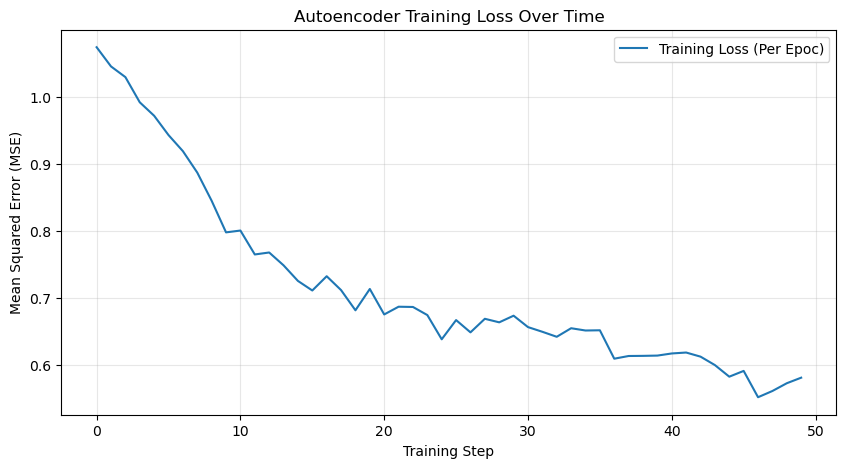

In [113]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(model.epoc_losses, label='Training Loss (Per Epoc)')
plt.title('Autoencoder Training Loss Over Time')
plt.xlabel('Training Step')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

As you see above by training more epocs we could have got a better loss, but its small enough so we'll pass.

Now let’s make a DataFrame from the reconstructed data and plot a boxplot to compare it to the original data.

In [114]:
# Get reconstructed and latent data
model.eval()
with torch.no_grad():
    X_recons, X_latent = model(X_tensor)
    X_recons = X_recons.numpy()  # Reconstructed data (13 dimensions)
    X_latent = X_latent.numpy()  # Latent representations (2 dimensions)
    
    # Inverse transform to original scale for comparison
    X_reconstructed = scaler.inverse_transform(X_recons)
    df_recons = pd.DataFrame(data=X_reconstructed, columns=feature_names)

In [115]:
df_recons.head(5) # notice we have shuffled the input in dataloader

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,13.992948,1.699031,2.413833,15.660712,112.885040,3.192288,3.383819,0.262265,2.200491,5.703047,1.132355,3.349651,1270.392212
1,13.480046,1.862654,2.380541,17.287718,106.838959,2.865358,2.906391,0.297586,1.988777,5.008412,1.091908,3.136691,1020.713318
2,13.541951,1.842905,2.384559,17.091343,107.568703,2.904818,2.964015,0.293323,2.014330,5.092252,1.096790,3.162395,1050.848633
3,14.250200,1.616963,2.430531,14.844666,115.917526,3.356263,3.623280,0.244549,2.306679,6.051451,1.152642,3.456464,1395.621826
4,12.980404,2.022048,2.348110,18.872660,100.949181,2.546881,2.441305,0.331994,1.782536,4.331735,1.052507,2.929237,777.489197


In [116]:
df_recons.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,12.996250,2.377857,2.364741,19.508877,100.210167,2.301863,1.989866,0.374985,1.609475,5.116563,0.959053,2.575414,741.788818
std,0.474700,0.587078,0.035712,1.955964,5.977441,0.525282,0.886975,0.078727,0.357940,1.235991,0.153376,0.607496,249.874603
min,12.428236,1.557036,2.312281,14.248770,94.367325,1.577247,0.675497,0.231613,1.102267,3.584038,0.696487,1.569579,506.337677
25%,12.578068,1.907547,2.328007,17.734116,95.632042,1.773769,1.075052,0.307277,1.245475,4.061500,0.796863,1.933411,553.174957
50%,12.947525,2.189806,2.373970,20.540785,97.175392,2.211688,1.951811,0.368207,1.565471,4.985923,1.011038,2.710895,601.820557
75%,13.339321,2.999754,2.396603,21.242570,105.180107,2.775659,2.775400,0.457406,1.930689,6.082018,1.080811,3.078262,952.209290
max,14.438052,3.376724,2.442724,21.520254,118.131927,3.476003,3.798139,0.499097,2.384221,7.156713,1.167456,3.534461,1487.067627


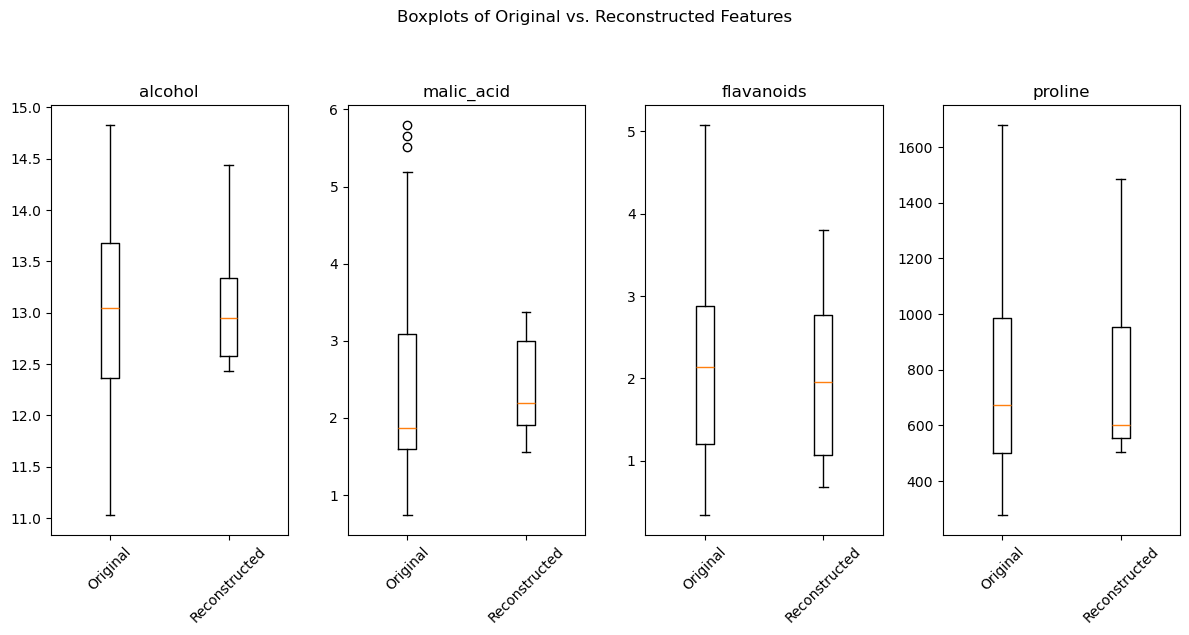

In [117]:
# Boxplots for selected features to compare the reconstructed data with original data
selected_features = [0, 1, 6, 12]  # alcohol, malic acid, flavanoids, proline
plt.figure(figsize=(12, 6))
for i, idx in enumerate(selected_features):
    plt.subplot(1, len(selected_features), i + 1)
    feature = feature_names[idx]
    plt.boxplot([df[feature], df_recons[feature]], labels=['Original', 'Reconstructed'])
    plt.title(feature_names[idx])
    plt.xticks(rotation=45)
plt.suptitle('Boxplots of Original vs. Reconstructed Features', y=1.05)
plt.tight_layout()
plt.show()

Based on the boxplot, the model performed well in capturing the central range of the features, but it did poorly in estimating the extreme values. This is somewhat expected, since we compressed 13 features into just 2 features using only two layers. If we increase the number of layers or slightly raise the number of features in the latent space, the model will likely perform more accurately.


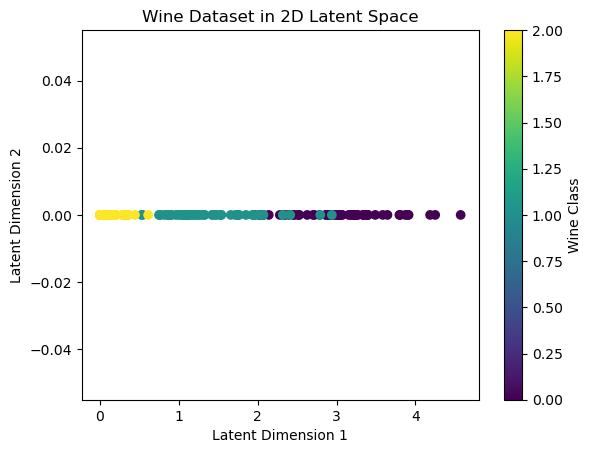

In [118]:
# Visualize the latent data
plt.scatter(X_latent[:, 0], X_latent[:, 1], c=y, cmap='viridis')
plt.title('Wine Dataset in 2D Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(label='Wine Class')
plt.show()

We plotted the latent space, as you can see above, the second dimension is always zero. This explains the weak performance of the model, since we had restricted the latent space to only two dimensions. Therefore, let’s increase the number of dimensions to **four** and take another look at these plots

In [119]:
# Initialize the model for the second time
model2 = Autoencoder(input_dim=X.shape[1], hidden_dim=8, latent_dim=4, learning_rate=0.01)

In [120]:
# train the model
trainer = L.Trainer(max_epochs=50)
trainer.fit(model2, train_dataloaders=train_dataloader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 148    | train
1 | decoder | Sequential | 157    | train
2 | loss    | MSELoss    | 0      | train
-----------------------------------------------
305       Trainable params
0         Non-trainable params
305       Total params
0.001     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` 

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [121]:
# Get reconstructed and latent data
model2.eval()
with torch.no_grad():
    X_recons, X_latent = model2(X_tensor)
    X_recons = X_recons.numpy()  # Reconstructed data (13 dimensions)
    X_latent = X_latent.numpy()  # Latent representations (2 dimensions)
    
    # Inverse transform to original scale for comparison
    X_reconstructed = scaler.inverse_transform(X_recons)
    df_recons = pd.DataFrame(data=X_reconstructed, columns=feature_names)

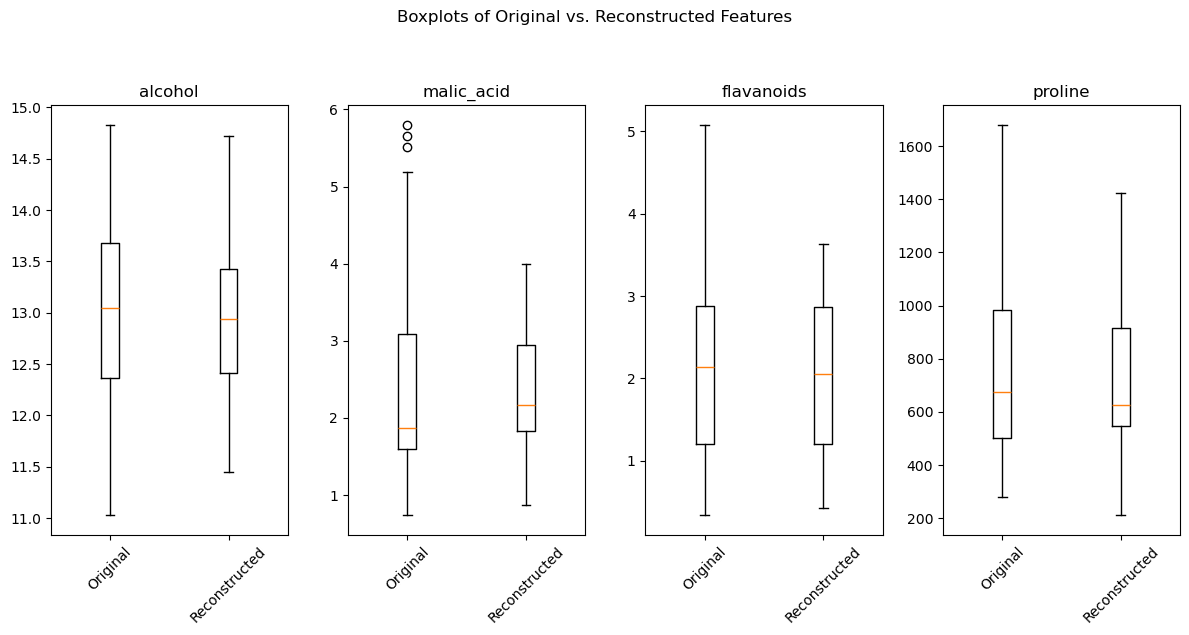

In [122]:
# Boxplots for selected features to compare the reconstructed data with original data
selected_features = [0, 1, 6, 12]  # alcohol, malic acid, flavanoids, proline
plt.figure(figsize=(12, 6))
for i, idx in enumerate(selected_features):
    plt.subplot(1, len(selected_features), i + 1)
    feature = feature_names[idx]
    plt.boxplot([df[feature], df_recons[feature]], labels=['Original', 'Reconstructed'])
    plt.title(feature_names[idx])
    plt.xticks(rotation=45)
plt.suptitle('Boxplots of Original vs. Reconstructed Features', y=1.05)
plt.tight_layout()
plt.show()

By increasing the number of features in the latent space, the model’s performance improved significantly. In this case, the latent space has 4 features, which cannot be directly visualized in two dimensions. Therefore, we use another dimensionality reduction method, called PCA, to project the latent layer data into 2D for visualization.

In [123]:
latentPCA = PCA(n_components=2)
latentScores = latentPCA.fit_transform(X_latent)

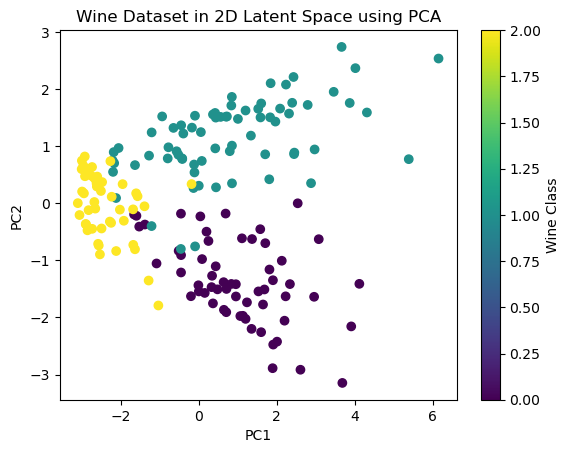

In [124]:
# Visualize the latent data using PCA
plt.scatter(latentScores[:, 0], latentScores[:, 1], c=y, cmap='viridis')
plt.title('Wine Dataset in 2D Latent Space using PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Wine Class')
plt.show()

## Why Vanilla Autoencoders Suck at Generating Data

The idea of generating samples in the autoencoder family is to pick a random value from the latent space and decode it to produce a new sample.
For example, let’s assume we have an encoder that compresses our data into a 2-dimensional latent space.
<img src="images/autoencoder2dlatent.png" alt="AutoEncoder 2D latent Space" style="margin: auto; display: block; width: 800px;">
Those five points in the diagram are our data, compressed by the encoder into two features. Now, if we want to generate a new sample from the autoencoder, we just pick a random point from the latent space, like the picture below shows.
<img src="images/2Dlatentspace.png" alt="A 2D latent Space" style="margin: auto; display: block; width: 500px;">
And here’s the problem: the model was trained on just those five data samples. It only really knows those points, because all the weights, biases, and coefficients are tuned just for them. That means it has no idea about the rest of the latent space, which I’ve shown in blue below.
<img src="images/2DlatentNotknown.png" alt="A 2D latent Space" style="margin: auto; display: block; width: 500px;">
So if we take a random point from the latent space and give it to the decoder, chances are high that what it generates won’t be valid. For example, if our data is made of images, the output picture will just look noisy. And if it’s tabular data, the generated sample will probably have weird, unrealistic feature values.

**Note**: Because of this problem with autoencoders, that the model knows nothing about regions of the latent space outside the training data, the autoencoder is considered an **irregular** latent space method. Methods that address this issue are referred to as **regularized** latent space methods.

Let’s actually generate a sample from the blue region. To do this, we’ll use the first model we trained, which had a 2D latent space. Our random point from the invalid region will be (8, 5). Let’s see what it gets decoded into.

In [125]:
fake_latent_sample = np.array([8, 5])

In [126]:
fake_generated_sample = model.decoder(torch.tensor(fake_latent_sample, dtype=torch.float32))
fake_generated_sample_df = pd.DataFrame(fake_generated_sample.detach(), feature_names)
fake_generated_sample_df

,0
alcohol,1.799748
malic_acid,-2.030339
ash,0.090531
alcalinity_of_ash,-2.675261
magnesium,1.771622
total_phenols,3.674681
flavanoids,3.844469
nonflavanoid_phenols,-1.803626
proanthocyanins,3.106809
color_intensity,0.226333


You see how bad the generated sample is, some features even got negative.Now that we’ve gotten familiar with dimensionality reduction and vanilla autoencoders, let’s dive into the main topic, **VAEs**.

## Introduction to Variational Autoencoders
VAEs make the latent space regularized, but how? They map the data into a probabilistic distribution. Typically, we want the latent space to follow a normal distribution, so the encoder is trained in such a way that the data eventually forms a standard normal distribution in the latent space. By doing this, our model becomes familiar with every point in the latent space, and any point we randomly choose can be decoded into a valid new sample.

**Note** that the latent space is designed to follow a standard normal distribution. Therefore, if the latent space has more than one dimension, this distribution becomes a multivariate normal distribution.

We continue with our two-dimensional latent space example.

So how does the model actually turn the latent space into a standard normal distribution? Let’s break it down.

First, the encoder generates a μ (the mean) and a σ (the standard deviation) for each training sample in the latent space.So basically, each sample turns into a little normal distribution.
<img src="images/probabilistic_latent_space.png" alt="A 2D probabilistic latent Space" style="margin: auto; display: block; width: 800px;">
Since the latent space is 2-dimensional, both μ and σ are also 2-dimensional, and the Σ (covariance matrix) becomes a 2×2 diagonal matrix.By forcing the covariance matrix to be diagonal, we assume that there is no correlation between the dimensions. And since our distribution is normal, this also means the dimensions are independent.

$\mu = \begin{vmatrix} \mu_{1} \\ \mu_{2} \end{vmatrix}$

$\sigma = \begin{vmatrix} \sigma_{1} \\ \sigma_{2} \end{vmatrix}$

$\Sigma  = \begin{vmatrix} \sigma_{1} & 0 \\ 0 & \sigma_{2} \\ \end{vmatrix}$

__________________________________________________________________________________


Next, from each normal distribution we randomly select a point and pass it to the decoder in order to reconstruct the original input data.
<img src="images/sampling_from_latent_space.png" alt="sampling_from_latent_space" style="margin: auto; display: block; width: 800px;">

Finally, we add a Kullback–Leibler (KL) divergence term between each of these normal distributions and the standard normal distribution to the model’s loss function.

So the loss function changes to this: reconstruction loss plus a KL divergence term.

$loss = \sum_{i}^{N}{\color{Red} (}\left\| x-x^{''}\right\|^{2} + D_{kl}{\color{Blue} (}N(\mu,\sigma^{2}I)||N(0,I){\color{Blue} )}{\color{Red} )}$

The closed form of the KL divergence for our model is as follows:

$D_{kl}(N(\mu,\sigma^{2}I)||N(0,I)) = \frac{1}{2}\sum_{i}^{n}(1+ln(\sigma_{i}^{2})-\sigma_{i}^{2} - \mu_{i}^{2})$

**what is Kullback–Leibler (KL) divergence?**

Kullback–Leibler (KL) divergence is a type of statistical distance that measures how one probability distribution differs from another. If the loss function only contains this term, the model will try to minimize this distance by making the normal distributions of the samples converge to a standard normal distribution. This causes them to cluster around the center of the diagram, as shown below.
<img src="images/kl_diagram.png" alt="kl_diagram" style="margin: auto; display: block; width: 500px;">
The issue with just using this term is that the samples get all tangled up, so reconstructing the data becomes a problem.
_________________________________________
As we saw with vanilla autoencoders, using only the reconstruction term in the loss function encourages the model to spread the samples as much as possible, which creates a lot of unknown space in the latent space like the picture below.
<img src="images/recons_diagram.png" alt="recons_diagram" style="margin: auto; display: block; width: 500px;">



___________________
By using both terms in the loss function, the model finds a trade-off to minimize the loss. The result is that the samples are neither too spread out nor too tangled together. The latent space becomes meaningful and regularized, leaving no unknown gaps between the samples. This allows us to pick any random point within this region to generate a new sample.
<img src="images/both_term_loss.png" alt="recons_diagram" style="margin: auto; display: block; width: 500px;">

_________
One more thing before we dive into the code: so far, we know that we give an input to the model, it generates μ and σ, and then, based on this normal distribution, it randomly chooses a point from the regularized latent space (called z) and passes it through the decoder to reconstruct the original data.

We also know that to train the weights and biases we need to use backpropagation. Now, suppose we want to update a weight in the encoder. Based on the chain rule, we can write:

$\frac{\mathrm{d} loss}{\mathrm{d} w_{inEncoder}} = \frac{\partial loss}{\partial deocder}*\frac{\partial decoder}{\partial z}*\frac{\partial z}{\partial ?}$

As you can see, we’re stuck, z is a random sample from the latent space, so there’s no equation for it and we can’t take derivatives.

**Reparameterization trick:** to fix this problem, We rewrite the sampling step as a deterministic function of μ σ, and an external noise source:

$z = \mu + \sigma\bigodot \epsilon $ 

$\epsilon \sim N(0, I)$

Now we can easily compute the derivatives with respect to μ and σ. After that, we can finally backprop into the encoder’s weights and biases like bellow

$\frac{\mathrm{d} loss}{\mathrm{d} w_{inEncoder}} = \frac{\partial loss}{\partial deocder}*\frac{\partial decoder}{\partial z}*\frac{\partial z}{\partial \mu}*\frac{\partial \mu}{\partial w_{inEncoder}} + \frac{\partial loss}{\partial deocder}*\frac{\partial decoder}{\partial z}*\frac{\partial z}{\partial \sigma}*\frac{\partial \sigma}{\partial w_{inEncoder}}$

_________
In summary, the entire process of a VAE is illustrated in the figure below.
<img src="https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png" alt="recons_diagram" style="margin: auto; display: block; width: 800px;">

Alright, let’s jump into coding and see how this works in practice.

## Create and Train the Variational Autoencoder model

In [11]:
batch_size = 16

In [128]:
class VAE(L.LightningModule):
    def __init__(self, input_dim, hidden_dims, latent_dim, learning_rate, beta=0):
        ## input_dim: it actully is the number of features(13 features)
        ## hidden_dim: hidden layer dimension
        ## latent_dim: latent_space dimension
        ## learning_rate: used to tune the gradient descent steps
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.beta = beta
        
        # Encoder
        self.encoder = None

        self.fc_mu = None
        self.fc_logvar = None
        
        # Decoder
        self.decoder = None
        
        # Mse Loss function
        self.mse_loss = nn.MSELoss(reduction='sum')

        self._define_model_architucture()
        
        # Lists to store losses for plotting
        self.total_batch_losses = []  # store total loss value for each batch
        self.total_epoc_losses = []   # store average total loss for batches in each epoc
        self.mse_batch_losses = []    # store mse loss for each batch
        self.mse_epoc_losses = []     # store average mse loss for batches in each epoc
        self.kl_batch_losses = []     # store kl loss for each batch
        self.kl_epoc_losses = []      # store average kl loss for batches in each epoc
        self.total_val_batch_losses = []
        self.total_val_epoc_losses = []


    def _define_model_architucture(self):
        ## ecoder
        encoder_layers = []
        in_dim = self.input_dim
        for h_dim in self.hidden_dims:
            encoder_layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.ReLU()
            ])
            in_dim = h_dim
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(self.hidden_dims[-1], self.latent_dim)
        self.fc_logvar = nn.Linear(self.hidden_dims[-1], self.latent_dim)
        
        ## decoder
        decoder_layers = []
        in_dim = self.latent_dim
        for h_dim in reversed(self.hidden_dims):
            decoder_layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.ReLU()
            ])
            in_dim = h_dim
        decoder_layers.append(nn.Linear(self.hidden_dims[0], self.input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar
        
    def vae_loss(self, recon_x, x, mu, logvar):
        mse_loss = self.mse_loss(recon_x, x)
        kl_div = -0.5 * self.beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return mse_loss + kl_div, mse_loss, kl_div

    def training_step(self, batch, batch_idx):
        ## The first thing we do is split 'batch'
        ## into the input and label values.
        ## Note that here, the labels are the inputs themselves
        
        inputs, labels = batch
        recon_x, mu, logvar = self.forward(inputs)
        total_loss, mse_loss, kl_div = self.vae_loss(recon_x, labels, mu, logvar)
        
        self.total_batch_losses.append(total_loss.item())
        self.mse_batch_losses.append(mse_loss.item())
        self.kl_batch_losses.append(kl_div.item())

        return total_loss

    def validation_step(self, batch, batch_idx):
        ## The first thing we do is split 'batch'
        ## into the input and label values.
        ## Note that here, the labels are the inputs themselves
        inputs, labels = batch
        recon_x, mu, logvar = self.forward(inputs)
        total_loss, mse_loss, kl_div = self.vae_loss(recon_x, labels, mu, logvar)
        
        self.total_val_batch_losses.append(total_loss.item())
        
        return total_loss
        
    def configure_optimizers(self):
        ## In this example, configuring the optimizer
        ## consists of passing it the weights and biases we want
        ## to optimize, which are all in self.parameters(),
        ## and setting the learning rate
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    
    ## "on_train_epoch_end" is a hook(event) within the LightningModule that is called at the end of each training epoch.
    def on_train_epoch_end(self):
        # Compute average losses for the epoch
        avg_total_loss = np.mean(self.total_batch_losses[-len(train_dataloader):])
        avg_mse_loss = np.mean(self.mse_batch_losses[-len(train_dataloader):])
        avg_kl_loss = np.mean(self.kl_batch_losses[-len(train_dataloader):])

        self.total_epoc_losses.append(avg_total_loss)
        self.mse_epoc_losses.append(avg_mse_loss)
        self.kl_epoc_losses.append(avg_kl_loss)

    
    ## "on_validation_epoch_end" is a hook(event) within the LightningModule that is called at the end of each validation epoch.
    def on_validation_epoch_end(self):
        # Compute average losses for the epoch
        avg_total_loss = np.mean(self.total_val_batch_losses[-len(val_dataloader):])
        self.total_val_epoc_losses.append(avg_total_loss)

Since we added a validation step to our model, let’s split the dataset into train, validation, and test sets.

In [129]:
# Split into training and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

In [130]:
df_train = pd.DataFrame(scaler.inverse_transform(X_train), columns=feature_names)
df_train["target"] = y_train
df_train.shape

(142, 14)

In [131]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False, drop_last=False)

In [132]:
# Initialize and train the model
vae_model = VAE(input_dim=X.shape[1], hidden_dims=[16, 8], latent_dim=2, learning_rate=0.01, beta=1)
trainer = L.Trainer(max_epochs=250, logger=False)
trainer.fit(vae_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /home/mazyar/Documents/programming/vae_tutorial/checkpoints exists and is not empty.


  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | mse_loss  | MSELoss    | 0      | train
1 | encoder   | Sequential | 360    | train
2 | fc_mu     | Linear     | 18     | train
3 | fc_logvar | Linear     | 18     | train
4 | decoder   | Sequential | 389    | train
-------------------------------------------------
785       Trainable params
0         Non-trainable params
785       Total params
0.003     Total estimated model params size (MB)

In [38]:
def plot_loss_curves(model):
    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(model.total_epoc_losses, label='Train Loss (recons + β*KL)')
    plt.plot(model.mse_epoc_losses, label='Train Loss (recon)')
    plt.plot(model.kl_epoc_losses, label='Train Loss (β*KL)')
    plt.plot(model.total_val_epoc_losses, label='Validation Loss')
    plt.title('VAE Training and Validation Loss')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

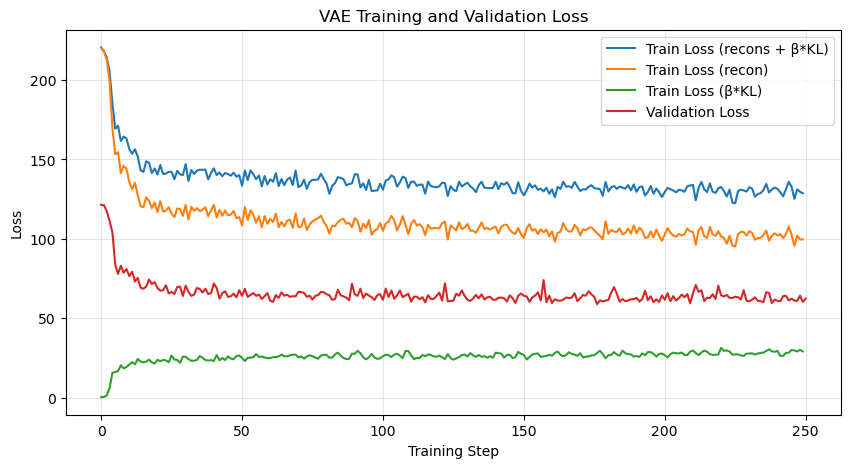

In [39]:
plot_loss_curves(vae_model)

The loss is stabled and it seems like adding more epocs doesnt imporve the loss. So, to avoid overfitting, we’ll stop training here and start generating synthetic data to test our model.

In [40]:
# Generate new data and assign labels
vae_model.eval()
with torch.no_grad():
    num_samples = df_train.shape[0]
    # z = latent represtation of the generated data
    z = torch.randn(num_samples, vae_model.latent_dim) # Generates the same size as train dataset 2D points from a normal distribution to pass into the decoder for new data generation.
    generated = vae_model.decode(z).numpy()
    generated_original_scale = scaler.inverse_transform(generated) # Back to original scale

    # Get latent representations of the train dataset and reconstructed data 
    recon, mu, logvar = vae_model(X_tensor)
    X_latent = mu.numpy() # Use mean as latent representation
    X_reconstructed = scaler.inverse_transform(recon.numpy()) 

Since a Variational Autoencoder is an unsupervised learning method, it doesn’t use labels during training. However, if we want to assign labels to the data it generates, we need an additional step. A common approach is to train a classifier (e.g., logistic regression, random forest, or a small neural network) on the original labeled dataset, and then use this classifier to predict the labels of the newly generated samples from the VAE. For the sake of this example, we’ll just use a simple k-Nearest Neighbors (kNN) classifier to assign labels to the generated samples.

In [41]:
# Assign labels to generated samples using k-NN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_scaled, y)
generated_labels = knn.predict(generated)

In [42]:
# Create DataFrame for reconstructed, and generated data

df_reconstructed = pd.DataFrame(X_reconstructed, columns=feature_names)
df_reconstructed['target'] = y

# DataFrame for generated data
df_generated = pd.DataFrame(generated_original_scale, columns=feature_names)
df_generated['target'] = generated_labels

## Evaluating the Quality of Data Generated by a Variational Autoencoder

When it comes to evaluating VAE models, the literature usually suggests two common approaches. First, we need to check that the distribution of the generated data is close enough to the original dataset. A common way to do this is by using the Kolmogorov–Smirnov (KS) similarity metric. Second, we look at ML efficacy, which means training a machine learning model on the generated data and testing it on the real test set. Let’s start by checking the similarity.

In [43]:
def statistic_results(df_train, df_synthetic, continuous_cols, categorical_cols):
    # For each feature, compute metrics
    total_score = 0
    for feature in continuous_cols:
        original = df_train[feature].values
        generated = df_synthetic[feature].values
        # KS Test
        ks_stat, ks_pvalue = ks_2samp(original, generated)
        total_score += 1-ks_stat
        print(f"{feature} KS Stat: {(1-ks_stat):.4f}")
    for feature in categorical_cols:
        score = TVComplement.compute( real_data=df_train[feature], synthetic_data=df_synthetic[feature])
        print(f"{feature} TV Stat: {(score):.4f}")
        total_score += score
    print(f"mean score is {(total_score/len(continuous_cols+categorical_cols)):.4f}")

In [44]:
statistic_results(df_train, df_generated, feature_names, ['target'])

alcohol KS Stat: 0.8380
malic_acid KS Stat: 0.5915
ash KS Stat: 0.7394
alcalinity_of_ash KS Stat: 0.7887
magnesium KS Stat: 0.7465
total_phenols KS Stat: 0.8451
flavanoids KS Stat: 0.8380
nonflavanoid_phenols KS Stat: 0.7254
proanthocyanins KS Stat: 0.8310
color_intensity KS Stat: 0.8239
hue KS Stat: 0.6901
od280/od315_of_diluted_wines KS Stat: 0.7817
proline KS Stat: 0.8451
target TV Stat: 0.9225
mean score is 0.7862


-----------------------
According to the literature, the similarity score should be above 80. As you can see, even with a simple model that isn’t well-tuned, we got a score about 80. Now, let’s plot the distribution to see the goodness of fit in action.

In [45]:

def plot_real_vs_synthetic(real_df, synth_df, continuous_cols, categorical_cols, bins=30, n_rows=5, n_cols=3):
    """
    Plots histograms for real vs synthetic data for each column.
    Arranges plots in a 3x5 grid (15 features max).
    """
    n = real_df.shape[1]
    plt.figure(figsize=(n_cols*4, n_rows*3))
    
    for i, col in enumerate(continuous_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        
        # Plot histogram for numeric data
        ax = sns.kdeplot(real_df[col], label="real", fill=True, alpha=0.3, legend=True)
        ax = sns.kdeplot(synth_df[col], label="synthetic", fill=True, alpha=0.3, legend=True)
        ax.legend(title='Dataset')
        
    for i, col in enumerate(categorical_cols, 1):
        idx = i + len(continuous_cols)
        plt.subplot(n_rows, n_cols, idx)
        df1 = real_df.copy()
        df2 = synth_df.copy()
        
        counts1 = df1[col].value_counts(normalize=True).reset_index()
        counts1.columns = [col, 'proportion']
        counts1['Source'] = "real"
        
        counts2 = df2[col].value_counts(normalize=True).reset_index()
        counts2.columns = [col, 'proportion']
        counts2['Source'] = "synthetic"
        # Combine into one DataFrame
        combined = pd.concat([counts1, counts2])
        sns.barplot(data=combined, x=col, y="proportion", hue="Source")
        # plt.title(col)
    plt.legend(title='Dataset') 
    plt.tight_layout()
    plt.show()


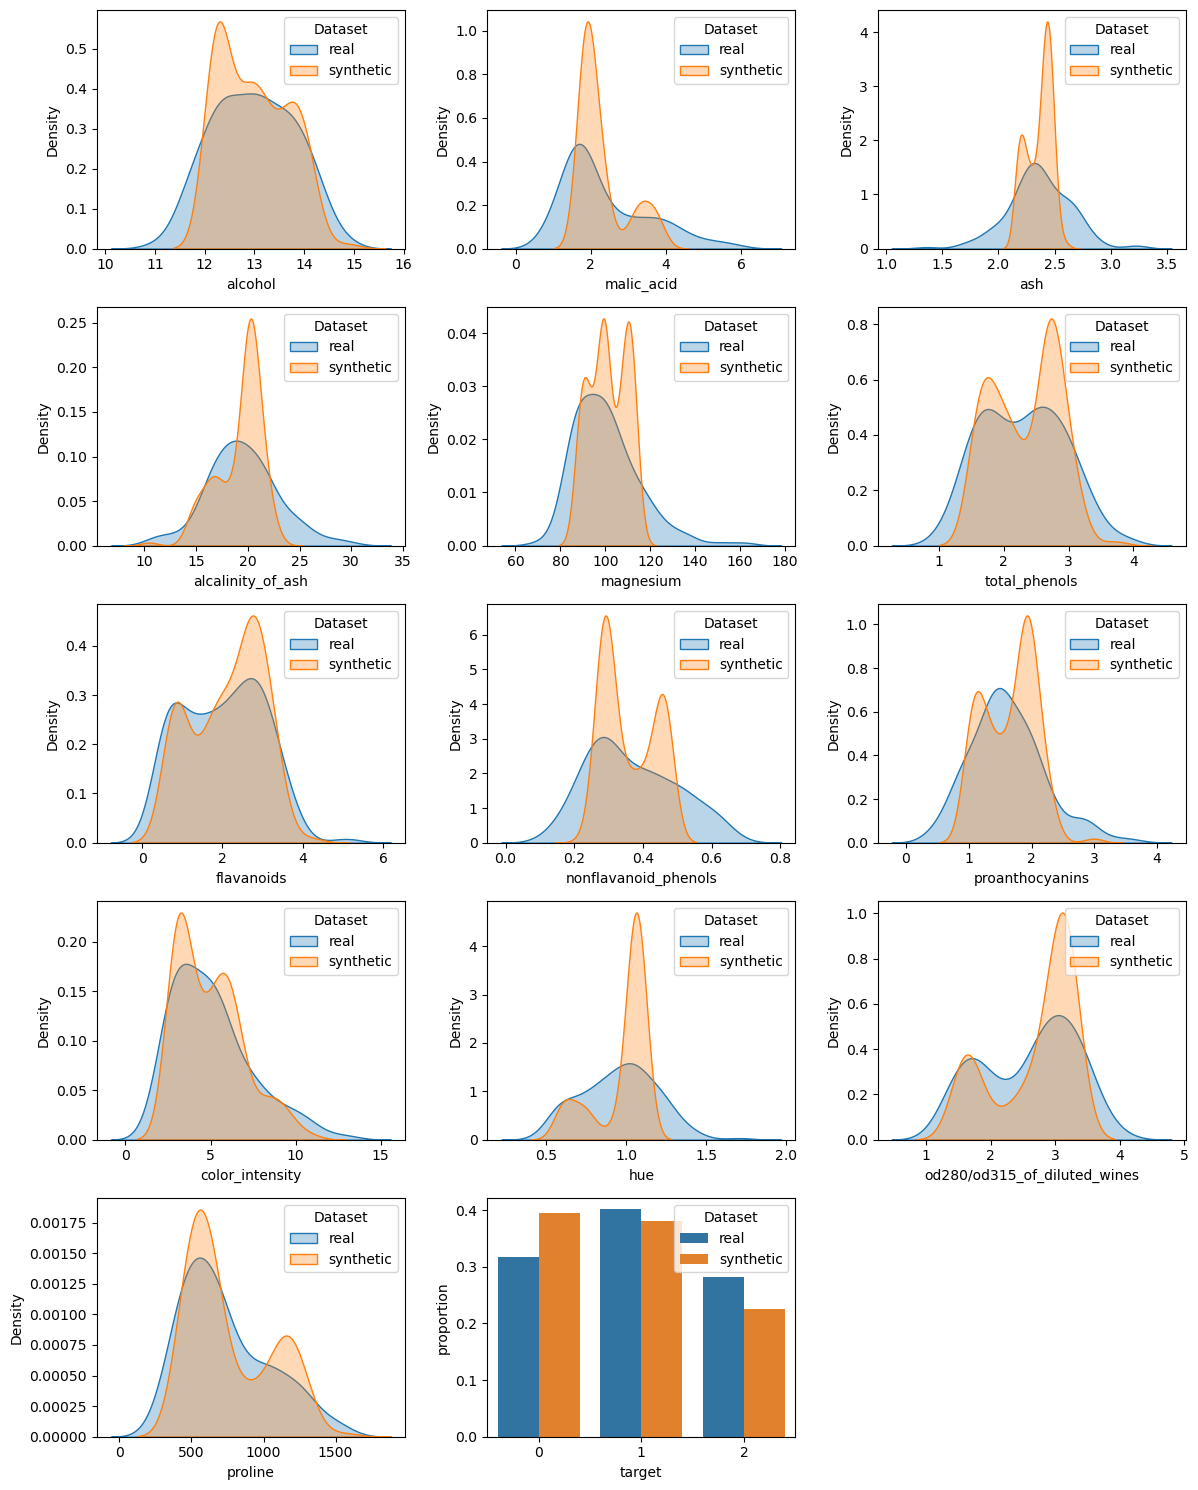

In [46]:
plot_real_vs_synthetic(df_train, df_generated, feature_names, ['target'])

Alright, now let’s plot a box plot comparing the generated dataset with the real dataset.

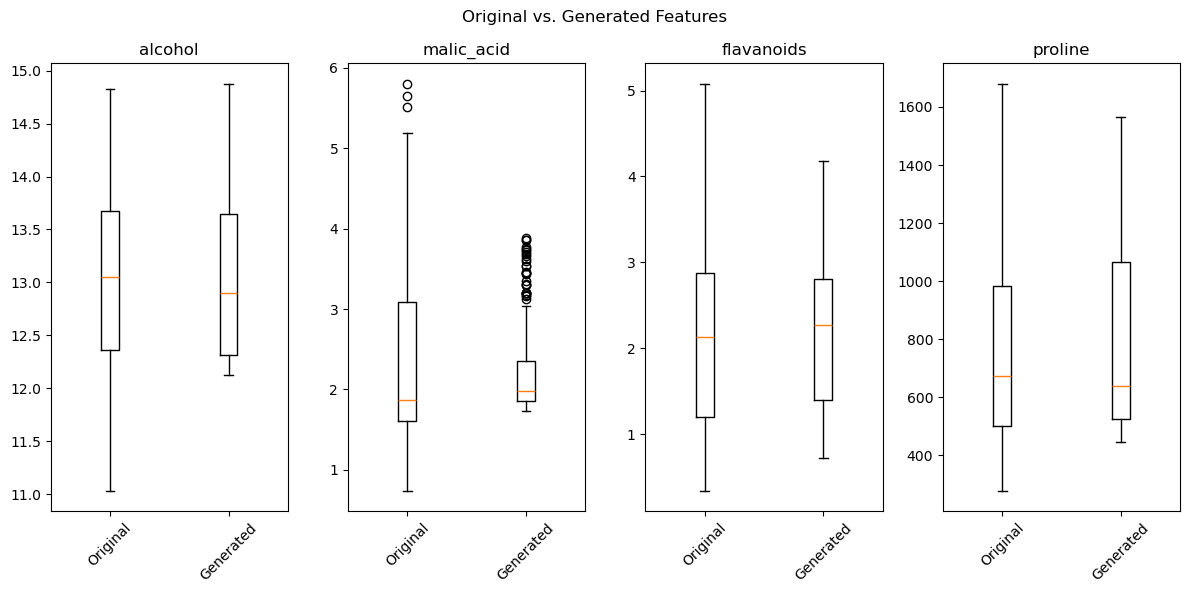

In [47]:
# Assume df (original) and df_generated are loaded
selected_features = ['alcohol', 'malic_acid', 'flavanoids', 'proline']

plt.figure(figsize=(12, 6))
for i, feature in enumerate(selected_features):
    plt.subplot(1, len(selected_features), i + 1)
    plt.boxplot([df[feature], df_generated[feature]], labels=['Original', 'Generated'])
    plt.title(feature)
    plt.xticks(rotation=45)
plt.suptitle('Original vs. Generated Features')
plt.tight_layout()
plt.show()

Now it’s time to check ML efficacy. We’ll use a few classification methods like Random Forest, Logistic Regression, AdaBoost, and a simple neural network classifier from scikit-learn.

In [48]:
def supervised_model_training(x_train, y_train, x_test, y_test, model_name):
  
     
    if model_name == 'lr':
        model  = LogisticRegression(random_state=SEED,max_iter=100) 
    elif model_name == 'ada':
        model  = AdaBoostClassifier(random_state=SEED,n_estimators=50)
    elif model_name == 'rf':      
        model = RandomForestClassifier(random_state=SEED)
    elif model_name == "mlp":
        model = MLPClassifier(random_state=SEED,max_iter=200)

    model.fit(x_train, y_train)
    pred = model.predict(x_test)
     
    predict = model.predict_proba(x_test)        
    acc = metrics.accuracy_score(y_test,pred)*100
    if len(np.unique(y_train))<3:
        f1_score = metrics.f1_score(y_test, pred, pos_label=1,average='binary')
    else:
        f1_score = metrics.f1_score(y_test, pred, pos_label=1,average='weighted') 
    macro_f1 = metrics.f1_score(y_test, pred, average='macro')
    micro_f1 = metrics.f1_score(y_test, pred, average='micro')
    return [acc,f1_score,macro_f1,micro_f1] 


In [49]:
def get_efficacy_metrics(X_gen, y_gen, X_train, y_train, X_test, y_test, 
                         classifiers={'ada':'NoScaler','lr':'Standard','mlp':'Standard', 'rf':'NoScaler'}):


    all_results_using_generated_dataset = []
    all_results_using_train_dataset = []
    for classifier in classifiers:
        scaler = classifiers[classifier]
        if scaler == "MinMax":
            scaler_real = MinMaxScaler()
            scaler_real.fit(X_train)
            X_train_scaled = scaler_real.transform(X_train)
            X_test_scaled = scaler_real.transform(X_test)
            scaler_fake = MinMaxScaler()
            scaler_fake.fit(X_train_fake)
            X_gen_scaled = scaler_fake.transform(X_gen)
        elif scaler == "Standard":
            scaler_real = StandardScaler()
            scaler_real.fit(X_train)
            X_train_scaled = scaler_real.transform(X_train)
            X_test_scaled = scaler_real.transform(X_test)
            scaler_fake = StandardScaler()
            scaler_fake.fit(X_gen)
            X_gen_scaled = scaler_fake.transform(X_gen)
        elif scaler == "NoScaler":
            X_train_scaled = X_train
            X_test_scaled = X_test
            X_gen_scaled = X_gen
        results_gen = supervised_model_training(X_gen_scaled, y_gen, X_test_scaled, y_test, classifier)
        results_train = supervised_model_training(X_train_scaled, y_train, X_test_scaled, y_test, classifier)
        
        all_results_using_generated_dataset.append(results_gen)
        all_results_using_train_dataset.append(results_train)
    return all_results_using_generated_dataset, all_results_using_train_dataset


In [50]:
X_gen = df_generated[feature_names].values
y_gen = df_generated['target'].values

X_train = df_train[feature_names].values
y_train = df_train['target'].values


In [51]:
classifiers = {'ada':'NoScaler','rf':'NoScaler','lr':'Standard','mlp':'Standard'}
result_mat_gen, result_mat_train = get_efficacy_metrics(X_gen, y_gen, X_train, y_train, scaler.inverse_transform(X_test), y_test)
result_df_using_generated_dataset  = pd.DataFrame(result_mat_gen, columns=["Acc","F1_Score","Macro","Micro"]) 
result_df_using_train_dataset  = pd.DataFrame(result_mat_train, columns=["Acc","F1_Score","Macro","Micro"]) 
result_df_using_generated_dataset.index = classifiers
result_df_using_train_dataset.index = classifiers
print("generated dataset scores:\n", result_df_using_generated_dataset, '\n')
print("train dataset scores:\n", result_df_using_train_dataset)

/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer:

generated dataset scores:
             Acc  F1_Score     Macro     Micro
ada   72.222222  0.701058  0.492063  0.722222
rf   100.000000  1.000000  1.000000  1.000000
lr   100.000000  1.000000  1.000000  1.000000
mlp   94.444444  0.944834  0.960234  0.944444 

train dataset scores:
             Acc  F1_Score     Macro     Micro
ada   94.444444   0.94363  0.958486  0.944444
rf   100.000000   1.00000  1.000000  1.000000
lr   100.000000   1.00000  1.000000  1.000000
mlp  100.000000   1.00000  1.000000  1.000000


Although our dataset is really small, and we didn’t tune our VAE model, it’s interesting that we still got such results. Vanilla VAEs work pretty well, but they also have some limits and weaknesses, which we’ll explain next.

## Limitation Of Vanilla VAEs

VAEs are great when working with continuous data, but they don’t handle categorical features very well. In our wine dataset, this wasn’t a problem because—apart from the target—we didn’t have categorical features, and we generated the target using machine learning.

Even with continuous data, VAEs can sometimes fail to capture the real behavior of the dataset. For example, some features might have multimodal distributions, but a vanilla VAE assumes that all features follow a single normal distribution, which isn’t always true. Another issue is with long-tail distributions, which vanilla VAEs also struggle to model. Long-tailed features are common, such as income in social datasets, and many other cases depending on the field and context.

Let’s plot the histograms of our dataset,you’ll notice that some features look multimodal and some show long-tailed behavior.

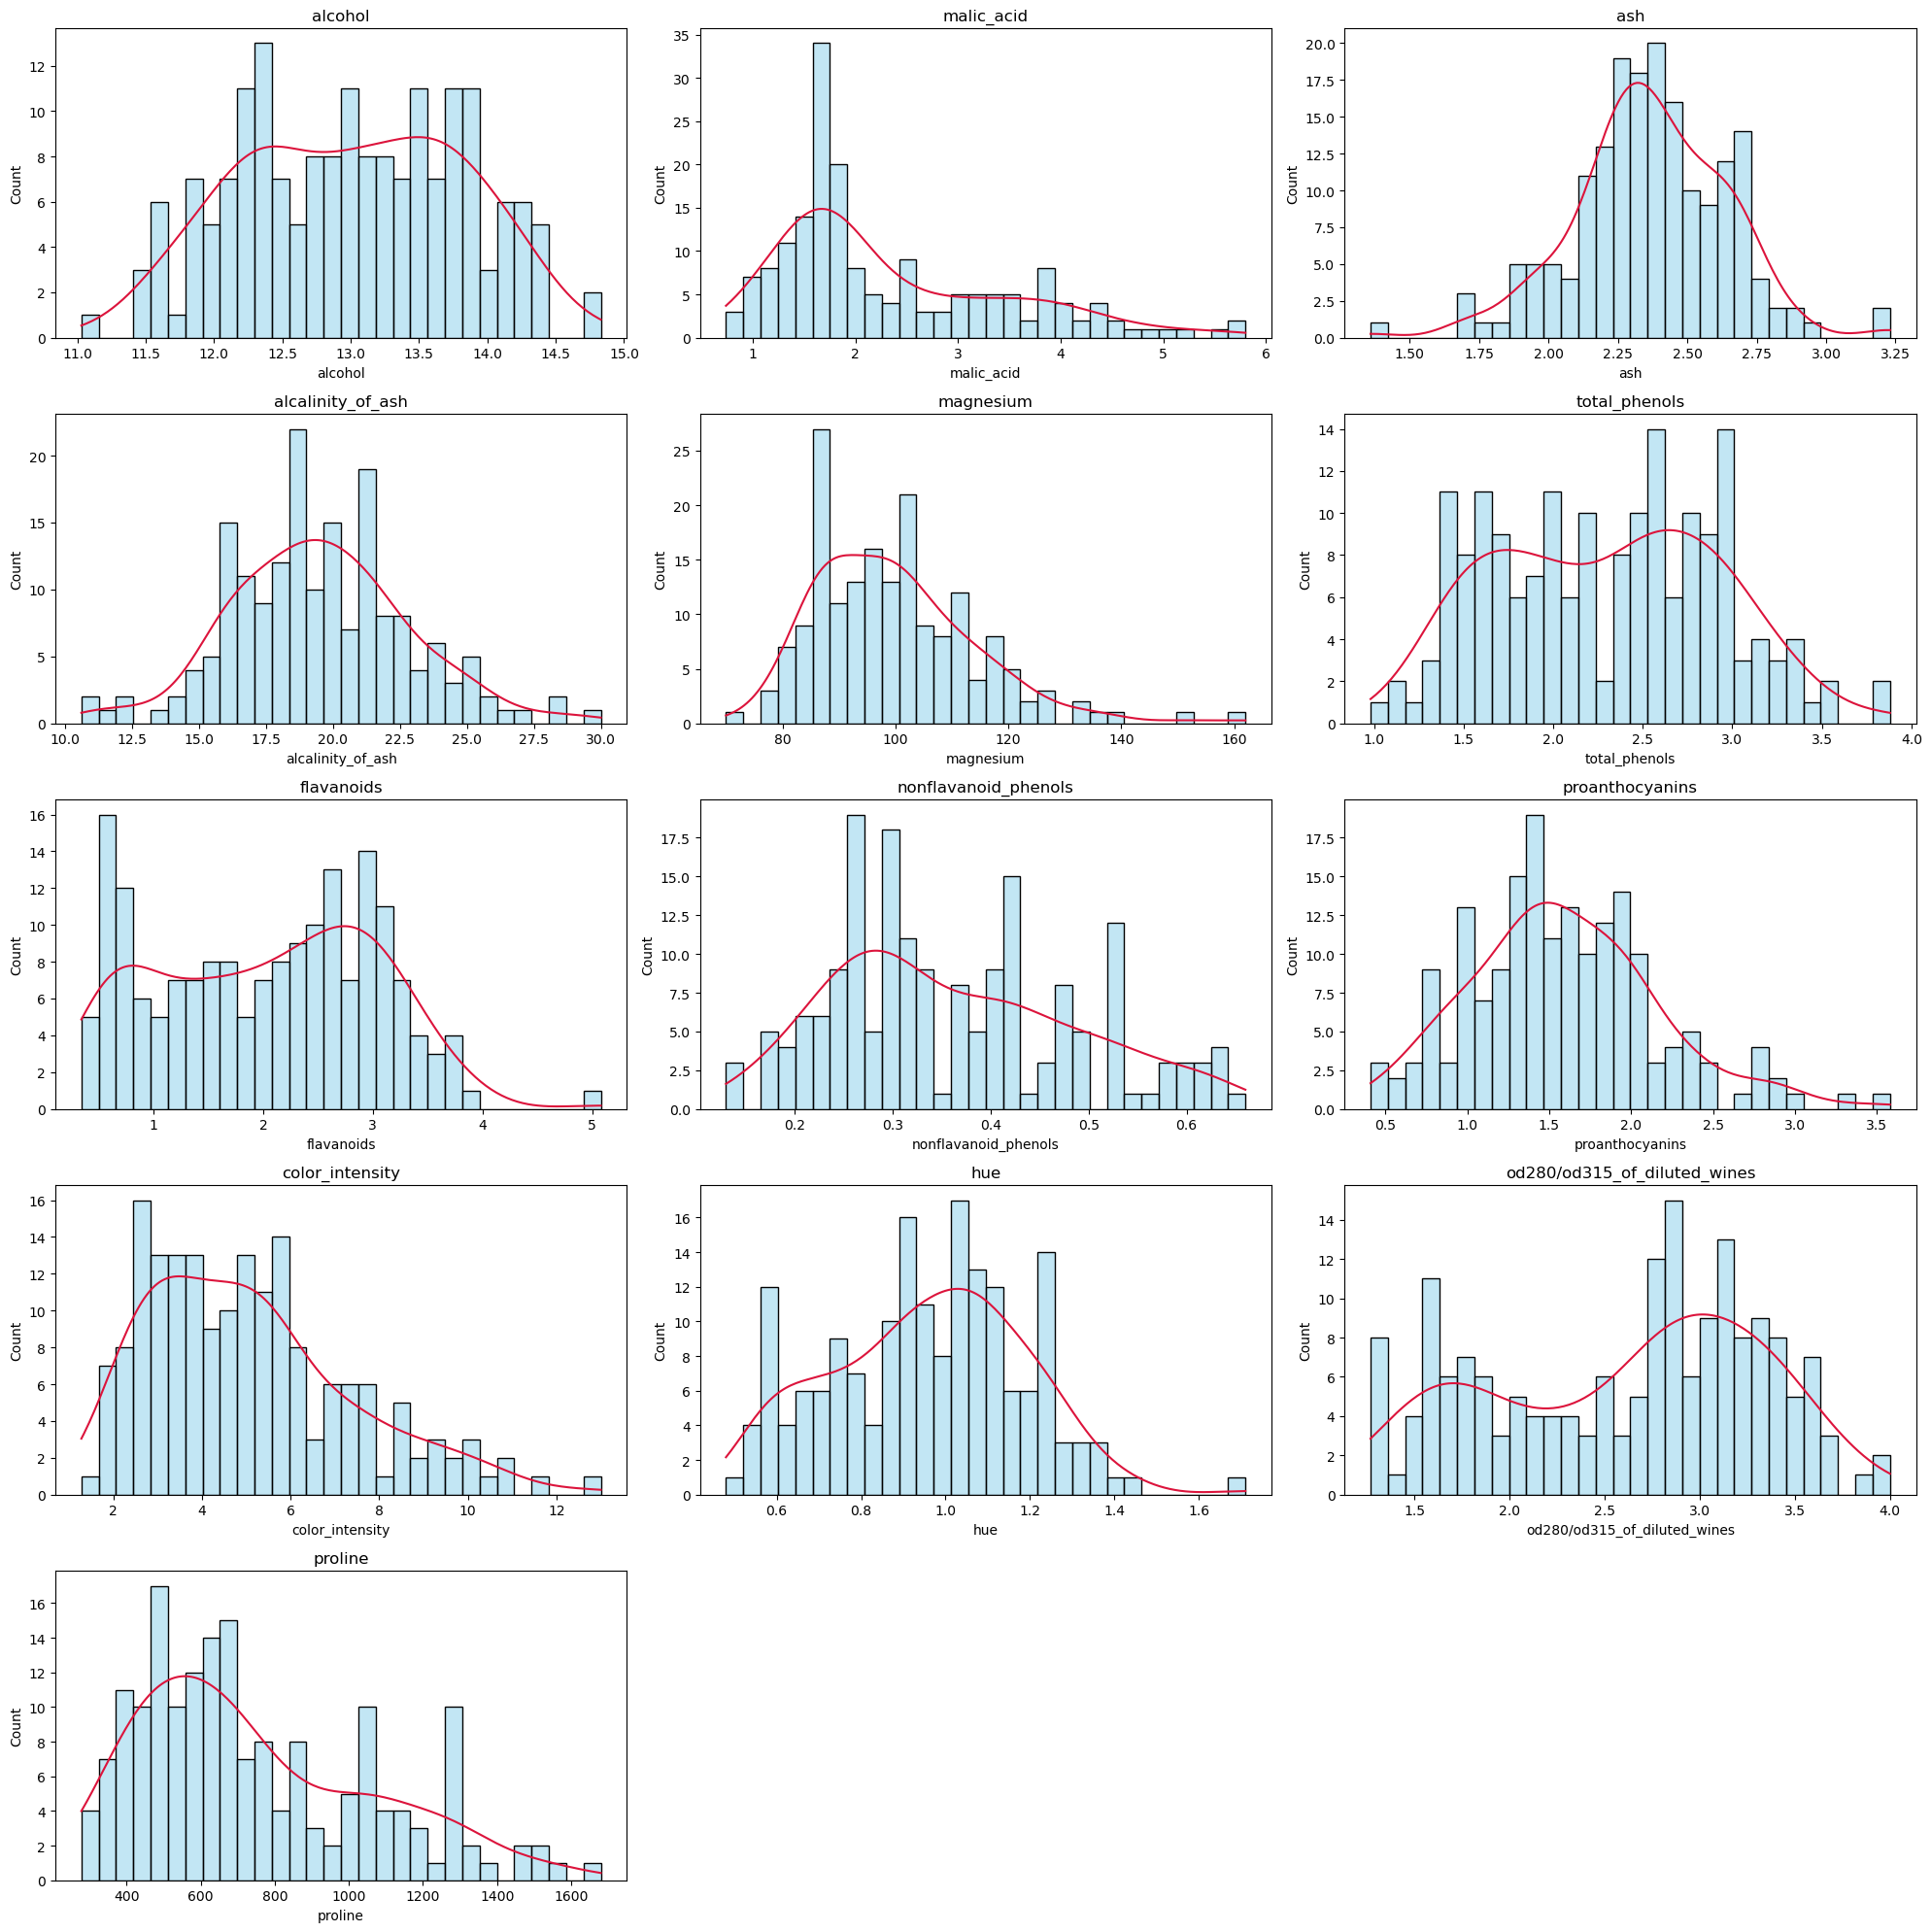

In [52]:
plt.figure(figsize=(20, 20))
for i, col in enumerate(feature_names[:], 1): 
    plt.subplot(5, 3, i)
    ax = sns.histplot(df[col], bins=30, kde=True, color="skyblue")  # KDE shows smooth distribution
    ax.lines[0].set_color('crimson')
    plt.title(col)
plt.tight_layout()
plt.show()

As you can see above, some features definitely don’t follow a single normal distribution. The good news is that with a bit of preprocessing and a small tweak to the final outputs of our VAE model, we can fix these issues. This approach was introduced by [Tazwar et al. (2024)](https://www.scitepress.org/Papers/2024/123024/123024.pdf). The article is freely available, easy to follow, and straightforward, so I won’t go into extra explanations here, I’ll just implement it below. I suggest you read the article first and then come back to continue with this post.

**Note**:  For the implementation of this article, I also used its source code. It’s not publicly available, but I contacted the authors and they kindly shared it with me.

## Tab-VAE Implementation

We need a preprocessor class to transform the dataset according to the article before we feed it to the model.

In [53]:
class TabTransformer:
    
    def __init__(self, singlemodal_cols, multimodal_cols , categorical_cols ,random_state = 42, epsilon=1e-6, n_clusters=10):
        self.singlemodal_cols = singlemodal_cols
        self.multimodal_cols = multimodal_cols
        self.continuous_cols = singlemodal_cols + multimodal_cols
        self.categorical_cols = categorical_cols
        self.random_state = random_state
        self.epsilon = epsilon
        self.n_clusters = n_clusters
        self.used_modes = {}
        self.lowers = {}  # store per-column lower bounds
        self.is_longtail = {}  # mark which cols are long-tail

        # Will be filled during fit
        self.gmms = {}
        self.continuous_mode_counts = {}
        self.continuous_mu_sigma = {}

        self.ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        self.categorical_class_counts = []  # for reconstruct

        # bookkeeping for vector layout
        self.cont_alpha_slices = {}
        self.cont_beta_slices = {}
        self.cat_slices = {}
        self.min_max_info = {}
        self.input_dim = None
        
    def fit(self, df):

        offset = 0
        for col in self.singlemodal_cols:
            X = df[[col]].values  # shape (n,1)
            self.min_max_info[col] = [float(X.min()), float(X.max())]
            scaler = StandardScaler()
            scaler.fit(X)
            mean = scaler.mean_
            std = np.sqrt(scaler.var_)
            self.continuous_mu_sigma[col] = [mean, std]
            self.cont_alpha_slices[col] = slice(offset, offset + 1)
            offset += 1
            
            
        ## fit GMM for each continuous column, choose n_components by BIC up to max_modes
        for col in self.multimodal_cols:
                
            X = df[[col]].values  # shape (n,1)
            self.min_max_info[col] = [float(X.min()), float(X.max())]
            
            gm = BayesianGaussianMixture(
              n_components = self.n_clusters, 
              weight_concentration_prior_type='dirichlet_process',
              weight_concentration_prior=0.001,
              max_iter=1000,n_init=1, random_state=SEED)
            gm.fit(X)
            self.gmms[col] = gm
            mode_freq = (pd.Series(gm.predict(X.reshape((-1, 1)))).value_counts().keys())
            important_modes = gm.weights_ > 0.05
            modes = []
            for i in range(self.n_clusters):
                if (i in (mode_freq)) & important_modes[i]:
                    modes.append(True)
                else:
                    modes.append(False)
            self.used_modes[col] = modes
            self.continuous_mode_counts[col] = sum(modes)
            means = gm.means_.reshape((1, self.n_clusters))
            means = means[:, self.used_modes[col]]
            stds = np.sqrt(gm.covariances_).reshape((1, self.n_clusters))
            stds = stds[:, self.used_modes[col]]
            self.continuous_mu_sigma[col] = [means, stds]

            self.cont_alpha_slices[col] = slice(offset, offset + 1)
            offset += 1
            k = self.continuous_mode_counts[col]
            self.cont_beta_slices[col] = slice(offset, offset + k)
            offset += k

        # fit OHE for categorical columns
        self.ohe.fit(df[self.categorical_cols].astype(object))
        # store number of classes per categorical column for reconstruction
        for i, col in enumerate(self.categorical_cols):
            arr = self.ohe.categories_
            c = arr[i]
            self.categorical_class_counts.append(len(c))
            self.cat_slices[col] = slice(offset, offset + len(c))
            offset += len(c)

        self.input_dim = offset
        # print(offset)
        return self


    def longtail_transform(self, df, skew_threshold=1, kurtosis_threshold=3):
        df_out = df.copy()
        for col in self.continuous_cols:
            skewness = skew(df[col])
            kurt = kurtosis(df[col], fisher=False)
            if (abs(skewness) > skew_threshold):  
                self.is_longtail[col] = True
                self.lowers[col] = df[col].min()
                l = self.lowers[col]
                if l > 0:
                    df_out[col] = np.log(df[col])
                else:
                    df_out[col] = np.log(df[col] - l + self.epsilon)
            else:
                self.is_longtail[col] = False
                
        return df_out
                

    def distribution_transform(self, df):

        n = len(df)
        out = np.zeros((n, self.input_dim), dtype=np.float32)
        
        df_copy = df.copy()
        for col in self.categorical_cols:
            df_copy[col] = df_copy[col].astype(object)

        for i_col, col in enumerate(self.singlemodal_cols):
            
            col_value = df[col].values.reshape(-1,1)
            val_alpha = (col_value - self.min_max_info[col][0]) / (self.min_max_info[col][1] - self.min_max_info[col][0])
            val_alpha = val_alpha*2 - 1
            # val_alpha = val_alpha.clip(-1,1)
            # mu, sigma = self.continuous_mu_sigma[col]
            # val_alpha = (col_value - mu) / (4.0 * sigma)
            # val_alpha = np.clip(val_alpha, -0.99, 0.99)
            # print(val_alpha.shape)
            out[:, self.cont_alpha_slices[col]] = val_alpha
            
        for i_col, col in enumerate(self.multimodal_cols):
            col_value = df[col].values.reshape(-1,1)
            mu, sigma = self.continuous_mu_sigma[col]
            gm = self.gmms[col]
            k = self.continuous_mode_counts[col]
            
            probs = gm.predict_proba(col_value)
            probs = probs[:, self.used_modes[col]]
            # print(probs[0], mu[0])
            probs += 1e-6
            probs = probs / probs.sum(axis=1, keepdims=True)
            cum_probs = np.cumsum(probs, axis=1)  # shape (n_samples, k-modes)
            r = np.random.rand(n, 1)  # shape (n_samples, 1)
            indices = (cum_probs >= r).argmax(axis=1)
            o = np.tile(np.arange(self.continuous_mode_counts[col]), (n, 1))
            mode = o[np.arange(o.shape[0]), indices].reshape(-1, 1)
            mode_flat = mode.reshape(-1) 
            # alpha normalization used in paper: alpha = (ci - mu_k) / (4 * sigma_k)
            # choose the chosen mode's mu/sigma
            # mu_k = mu[:,mode].reshape(-1, 1)
            mu_k = mu[0, mode_flat].reshape(-1, 1)
            sigma_k = sigma[0, mode_flat].reshape(-1, 1) #np.array(list(map(lambda x: x if x > 1e-6 else 1., sigma[:, mode].reshape(-1)))).reshape(-1, 1)
            val_alpha = (col_value - mu_k) / (4.0 * sigma_k)
            val_alpha = np.clip(val_alpha, -0.99, 0.99)
            # one-hot
            mode_onehot = np.zeros((n, k), dtype=np.float32)
            
            mode_onehot[np.arange(n), mode.reshape(-1)] = 1.0
            
            out[:, self.cont_alpha_slices[col]] = val_alpha
            out[:, self.cont_beta_slices[col]] = mode_onehot

        ohe_cat = self.ohe.transform(df_copy[self.categorical_cols])
        for i_col, col in enumerate(self.categorical_cols):
            col_value = df_copy[col]
            first_cat = self.categorical_cols[0]
            start = self.cat_slices[first_cat].start
            sl = self.cat_slices[col]
            out[:, sl] = ohe_cat[:, sl.start - start:sl.stop - start]
            
        return out
    
        
    def inverse_transform(self, x):
        """
        """
        keys = self.continuous_cols + self.categorical_cols
        out = {k: [] for k in keys}
        invalids = [] 

        for i_col, col in enumerate(self.singlemodal_cols):
            
            alpha_slice = self.cont_alpha_slices[col]
            alpha = x[:, alpha_slice].numpy().astype(float)
            # alpha = alpha.clip(-1,1)
            alpha = (alpha + 1)/2
            val = alpha * (self.min_max_info[col][1] - self.min_max_info[col][0]) + self.min_max_info[col][0]
            for idx,value in enumerate(val.squeeze()):
                if (value < self.min_max_info[col][0]) | (value > self.min_max_info[col][1]):
                    # print(value < self.min_max_info[col][0], value > self.min_max_info[col][1])
                    invalids.append(idx)
                # if value < self.min_max_info[col][0]:
                #     value = self.min_max_info[col][0]
                # elif value > self.min_max_info[col][1]:
                #     value = self.min_max_info[col][1]
                
            if self.is_longtail[col]:
                l = self.lowers[col]
                if l > 0:
                    val = np.exp(val)
                else:
                    val = np.exp(val) + l - self.epsilon
            out[col] = val.squeeze()
            
        for i_col, col in enumerate(self.multimodal_cols):
            
            
            alpha_slice = self.cont_alpha_slices[col]
            beta_slice = self.cont_beta_slices[col]
            alpha = x[:, alpha_slice].numpy().astype(float)
            beta = x[:, beta_slice].numpy().astype(float)
        
            mode = np.argmax(beta, axis=1).astype(int).reshape(-1, 1)
            mu, sigma = self.continuous_mu_sigma[col]
            # print(beta.shape, mode.shape, mu.shape)
            mu_k = mu[:,mode].reshape(-1, 1)
            sigma_k = sigma[:, mode].reshape(-1,1)
            # alpha = np.clip(alpha, -1, 1)
            val = alpha * 4.0 * sigma_k + mu_k
            for idx,value in enumerate(val.squeeze()):
                if (value < self.min_max_info[col][0]) | (value > self.min_max_info[col][1]):
                    # print(value < self.min_max_info[col][0], value > self.min_max_info[col][1])
                    invalids.append(idx)
                # if value < self.min_max_info[col][0]:
                #     value = self.min_max_info[col][0]
                # elif value > self.min_max_info[col][1]:
                #     value = self.min_max_info[col][1]
                
            if self.is_longtail[col]:
                l = self.lowers[col]
                if l > 0:
                    val = np.exp(val)
                else:
                    val = np.exp(val) + l - self.epsilon
            
            out[col] = val.squeeze()
        for i, col in enumerate(self.categorical_cols):
            
            # gamma_logits = total_gamma_logits[i][i_row]
            
            gamma_slice = transformer.cat_slices[col]
            gamma = x[:, gamma_slice]
            cat = np.argmax(gamma, axis=1).numpy().astype(int)
            # convert integer back to category via the fitted categories_
            category = self.ohe.categories_[i][cat]
            out[col] = category
        df = pd.DataFrame.from_dict(out)
        df[self.continuous_cols] = df[self.continuous_cols].astype(float)
        df.drop(index=invalids, inplace=True)
        return df

Here’s the Tab-VAE implementation. Just a note: the beta coefficient controls how much the KL divergence contributes to the total loss. For the first 50 epochs, we set it to zero so the model can really learn the data and spread out each sample as much as possible. After 50 epochs, we gradually increase it until it reaches 0.5. The same idea applies to the tau coefficient, which we decrease from 1 to 0.1 so the model can better learn the categorical data.

In [54]:
class TabVAE(L.LightningModule):
    def __init__(self, input_dim, hidden_dims, latent_dim, transformer,
                 tau=1, learning_rate = 1e-3, beta = 1.0):
        super().__init__()
        #self.save_hyperparameters()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.transformer = transformer
        self.tau = tau
        self.learning_rate = learning_rate
        self.beta = beta
        self.current_epoc = 0
        self.current_step = 0

        # Encoder
        self.encoder = None

        self.fc_mu = None
        self.fc_logvar = None
        
        # Decoder
        self.decoder = None

        # Generated Params
        self.fc_mu_out = None
        self.fc_logvar_out = None
        

        # Cross Entropy function
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction="sum")

        self._define_model_architucture()
        
        # Lists to store losses for plotting
        self.total_batch_losses = []  # store total loss value for each batch
        self.total_epoc_losses = []   # store average total loss for batches in each epoc
        self.mse_batch_losses = []    # store mse loss for each batch
        self.mse_epoc_losses = []     # store average mse loss for batches in each epoc
        self.kl_batch_losses = []     # store kl loss for each batch
        self.kl_epoc_losses = []      # store average kl loss for batches in each epoc
        self.total_val_batch_losses = []
        self.total_val_epoc_losses = []
        
    def _define_model_architucture(self):
        ## ecoder
        encoder_layers = []
        in_dim = self.input_dim
        for h_dim in self.hidden_dims:
            encoder_layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.LeakyReLU()
            ])
            in_dim = h_dim
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu_z = nn.Linear(self.hidden_dims[-1], self.latent_dim)
        self.fc_logvar_z = nn.Linear(self.hidden_dims[-1], self.latent_dim)
        
        ## decoder
        decoder_layers = []
        in_dim = self.latent_dim
        for h_dim in reversed(self.hidden_dims):
            decoder_layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.LeakyReLU()
            ])
            in_dim = h_dim
        decoder_layers.append(nn.Linear(self.hidden_dims[0], self.input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

        self.logvars = nn.Parameter(torch.ones(len(self.transformer.continuous_cols)))
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu_z(h)
        logvar = self.fc_logvar_z(h)
        return mu, logvar
        
    def gaussian_reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def gumbel_activation(self, probs):
        
        return nn.functional.gumbel_softmax(probs, tau=self.tau, hard=True)

    def decode(self, z):         
        return self.decoder(z), self.logvars

    def gaussian_log_likelihood(self, x, mu, logvar):
        # Gaussian log-likelihood: -0.5 * [log(2pi) + log(sigma^2) + (x - mu)^2 / sigma^2]
        sigma = torch.exp(0.5 * logvar)
        
        return -0.5 * (torch.log(torch.tensor(2 * np.pi)) + logvar + ((x - mu) ** 2) / (sigma ** 2)).sum()
        

    def forward(self, x):
        mu, logvar_z = self.encode(x)
        z = self.gaussian_reparameterize(mu, logvar_z)
        h, logvar_x = self.decode(z)
        
        return h, mu, logvar_z, logvar_x
        

    def get_beta(self):
        beta = float(min(0.5, max(0, self.current_epoc - 20 ) / (epocs_for_beta_tuning-20)))
        return beta

    def get_tau(self):
        frac = float(min(1.0, max(0, self.current_epoc - 50 ) / (epocs_for_beta_tuning-50)))
        tau = 1-frac + 0.1*frac
        return tau
        
        
    def vae_loss(self, recon_x, x, mu, logvar_z, logvar_out):
        nll_loss = 0
        beta_cross_entropy_loss = 0
        gamma_cross_entropy_loss = 0

        for idx, col in enumerate(self.transformer.singlemodal_cols):
            alpha_slice = transformer.cont_alpha_slices[col]
            
            recon_alpha = torch.tanh(recon_x[:, alpha_slice])
            real_alpha = x[:, alpha_slice]

            nll_loss += -self.gaussian_log_likelihood(real_alpha, recon_alpha, logvar_out[idx])
            
        #############
        for idx, col in enumerate(self.transformer.multimodal_cols):
            i = idx + len(self.transformer.singlemodal_cols)
            alpha_slice = transformer.cont_alpha_slices[col]
            beta_slice = transformer.cont_beta_slices[col]
            
            recon_alpha = torch.tanh(recon_x[:, alpha_slice])
            real_alpha = x[:, alpha_slice]

            recon_beta = self.gumbel_activation(recon_x[:, beta_slice])
            real_beta = x[:, beta_slice]
            nll_loss += -self.gaussian_log_likelihood(real_alpha, recon_alpha, logvar_out[i])
            # nll_loss += self.nll_loss(real_alpha, recon_alpha, torch.exp(0.5 * logvar_out[idx]).clamp(min=1e-3))
            beta_cross_entropy_loss += self.cross_entropy_loss(recon_beta, real_beta)
        #############
        for idx, col in enumerate(self.transformer.categorical_cols):
            
            gamma_slice = transformer.cat_slices[col]

            recon_gamma = self.gumbel_activation(recon_x[:, gamma_slice])
            real_gamma = x[:, gamma_slice]
            
            gamma_cross_entropy_loss += self.cross_entropy_loss(recon_gamma, real_gamma)
            
            
        kl_div = -0.5 * self.beta * torch.sum(1 + logvar_z - mu.pow(2) - logvar_z.exp())
        recon_loss = nll_loss + beta_cross_entropy_loss + 2*gamma_cross_entropy_loss
        
        return recon_loss + kl_div, recon_loss, kl_div

    def training_step(self, batch, batch_idx):
        ## The first thing we do is split 'batch'
        ## into the input and label values.
        ## Note that here, the labels are the inputs themselves
        
        self.logvars.data.clamp_(-5,2.)
        
        self.current_step += 1
        self.current_epoc = int(self.current_step/len(train_dataloader)) 
        
        self.beta = self.get_beta()
        self.tau = self.get_tau()
        
        X, label = batch
        
        recon_x, mu, logvar_z, logvar_out = self.forward(X)
        total_loss, recon_loss, kl_div = self.vae_loss(recon_x, X , mu, logvar_z, logvar_out)

        self.total_batch_losses.append(total_loss.item())
        self.mse_batch_losses.append(recon_loss.item())
        self.kl_batch_losses.append(kl_div.item())

        return total_loss

    def validation_step(self, batch, batch_idx):
        X, label = batch

        recon_x, mu, logvar_z, logvar_out = self.forward(X)
        total_loss, recon_loss, kl_div = self.vae_loss(recon_x, X , mu, logvar_z, logvar_out)
        
        self.total_val_batch_losses.append(total_loss.item())
        # self.log("val_loss", total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        ## In this example, configuring the optimizer
        ## consists of passing it the weights and biases we want
        ## to optimize, which are all in self.parameters(),
        ## and setting the learning rate
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    
    ## "on_train_epoch_end" is a hook(event) within the LightningModule that is called at the end of each training epoch.
    def on_train_epoch_end(self):
        # Compute average losses for the epoch
        avg_total_loss = np.mean(self.total_batch_losses[-len(train_dataloader):])
        avg_mse_loss = np.mean(self.mse_batch_losses[-len(train_dataloader):])
        avg_kl_loss = np.mean(self.kl_batch_losses[-len(train_dataloader):])

        self.total_epoc_losses.append(avg_total_loss)
        self.mse_epoc_losses.append(avg_mse_loss)
        self.kl_epoc_losses.append(avg_kl_loss)

    ## "on_validation_epoch_end" is a hook(event) within the LightningModule that is called at the end of each validation epoch.
    def on_validation_epoch_end(self):
        # Compute average losses for the epoch
        avg_total_loss = np.mean(self.total_val_batch_losses[-len(val_dataloader):])
        self.total_val_epoc_losses.append(avg_total_loss)


    def sample(self, recon_x, logvar_out):
        
        x = torch.zeros(recon_x.shape)
        
        for idx, col in enumerate(self.transformer.singlemodal_cols):
            alpha_slice = transformer.cont_alpha_slices[col]
            x[:, alpha_slice] = torch.tanh(recon_x[:, alpha_slice])
            
        for idx, col in enumerate(self.transformer.multimodal_cols):
            
            alpha_slice = transformer.cont_alpha_slices[col]
            beta_slice = transformer.cont_beta_slices[col]
            
            x[:, alpha_slice] = torch.tanh(recon_x[:, alpha_slice])
            x[:, beta_slice] = self.gumbel_activation(recon_x[:, beta_slice])

        for idx, col in enumerate(self.transformer.categorical_cols):
            
            gamma_slice = transformer.cat_slices[col]

            x[:, gamma_slice] = self.gumbel_activation(recon_x[:, gamma_slice])

        return x
    
        

Now let’s train a Tab-VAE model. First, we need to set up our input data. To do that, we decide which features are multimodal and which are single-mode. We’ll judge this by eye: we fit a normal curve to each feature and see if it can be explained by a single normal distribution. If not, we’ll treat it as multimodal. Also, for long-tailed features, as suggested in the paper, we first take the natural log of the feature and then check if it’s single-mode or multimodal.

To see if a feature’s distribution is long-tailed, we check its skewness. If the absolute skewness is bigger than 0.75, we apply a log (ln) transformation to that feature.

skewness alcohol -0.05104747165391963
skewness malic_acid 1.0308694978039965
skewness ash -0.1752067779256028
skewness alcalinity_of_ash 0.21124732832155219
skewness magnesium 1.088914887210701
skewness total_phenols 0.08590677016719508
skewness flavanoids 0.025129482208428075
skewness nonflavanoid_phenols 0.44634901064702254
skewness proanthocyanins 0.5127690334109938
skewness color_intensity 0.8612480547740543
skewness hue 0.020913119068882775
skewness od280/od315_of_diluted_wines -0.30468992894361013
skewness proline 0.7613361671993626


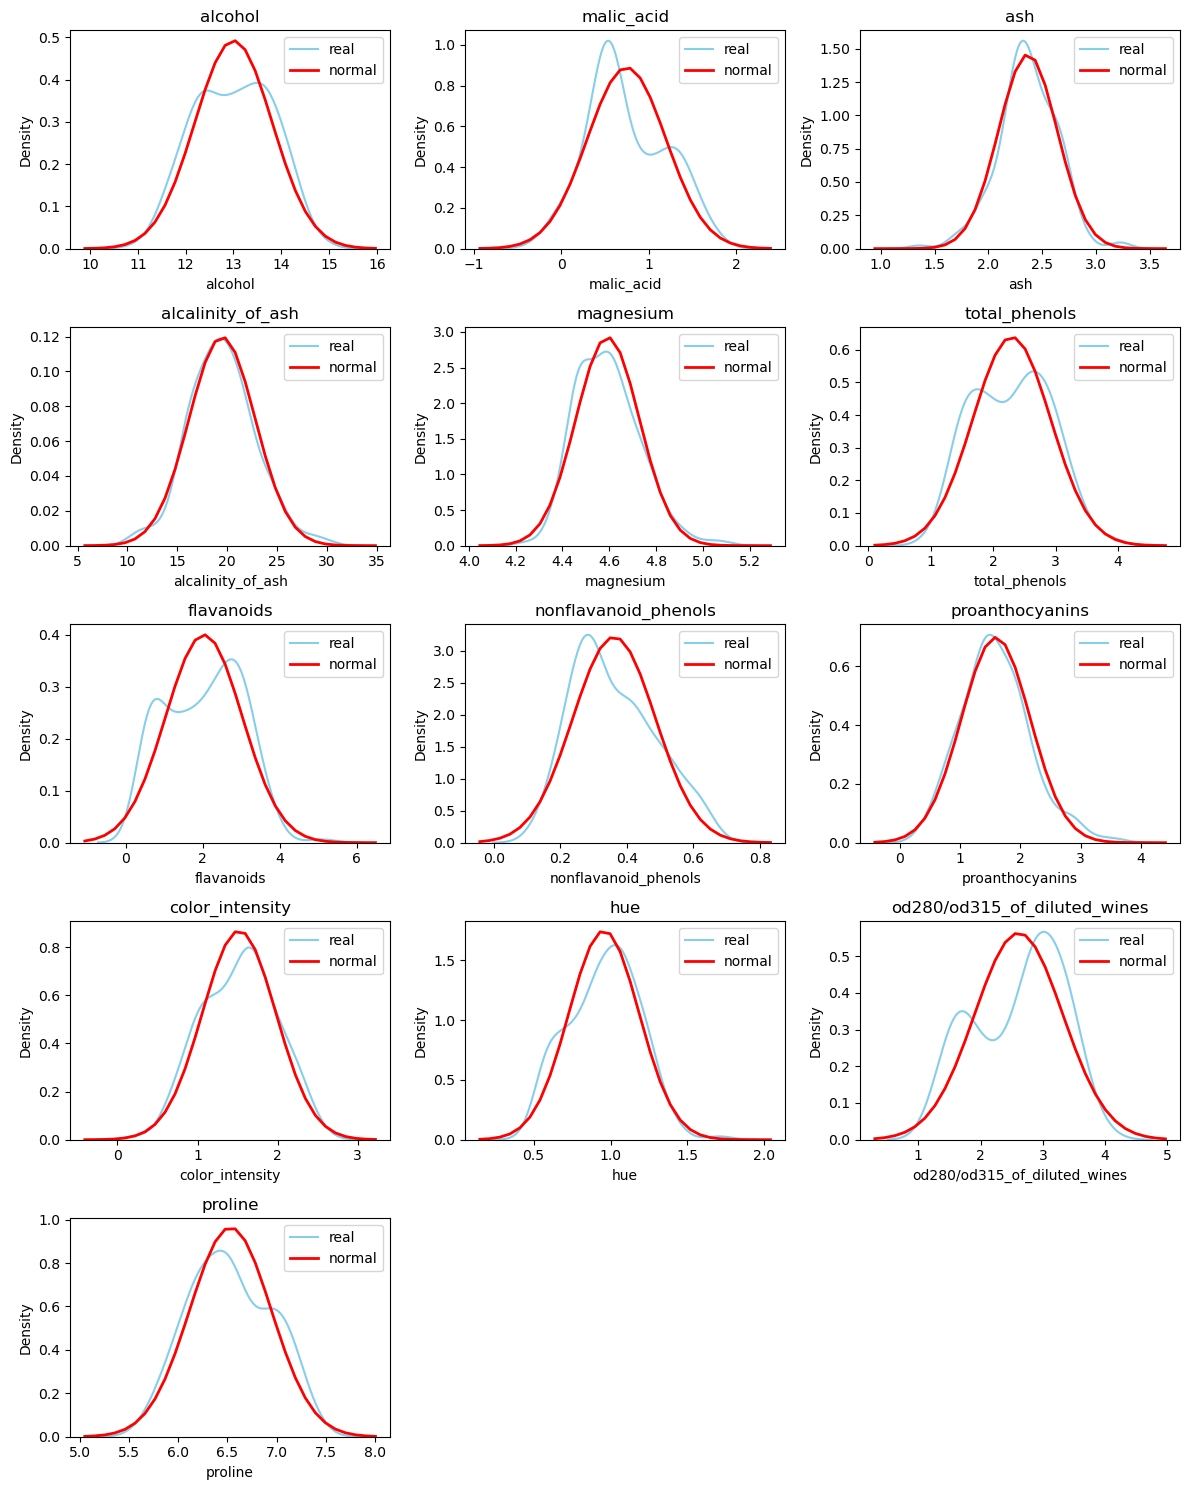

In [88]:
plt.figure(figsize=(12, 15))
for i, col in enumerate(feature_names[:], 1):  # first 6 features
    print("skewness",col,skew(df[col]))
    if (abs(skew(df[col])) > 0.75):
        val = np.log(df[col])
    else:
        val = df[col]
    mu, sigma = norm.fit(val) 
    plt.subplot(5, 3, i)
    ax = sns.kdeplot(val, label='real', color="skyblue")  # KDE shows smooth distribution
    ax.legend(title='data distribution')
    plt.title(col)
    # Create range for curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 30)
    p = norm.pdf(x, mu, sigma)
    # Plot normal curve
    plt.plot(x, p, 'r', linewidth=2, label='normal')
    plt.legend()
plt.tight_layout()
plt.show()


As you can see from the plot above, the features 'od280/od315_of_diluted_wines' and 'malic_acid' and 'nonflavanoid_phenols' look like they follow a multimodal distribution.

In [133]:
multimodal_cols = ['malic_acid', 'od280/od315_of_diluted_wines', 'nonflavanoid_phenols', ]

singlemodal_cols = ['total_phenols', 'flavanoids', 'alcohol','ash', 
                    'alcalinity_of_ash', 'magnesium', 'proanthocyanins', 'color_intensity', 'hue', 'proline']

continuous_cols = singlemodal_cols + multimodal_cols

categorical_cols = ['target']

In [134]:
epocs_for_beta_tuning = 400 # beta is gonna increase from 0 to 0.5 at 400 epocs
batch_size = 16

In [135]:
X = df[continuous_cols].values
y = df['target'].values

In [136]:
transformer = TabTransformer(singlemodal_cols=singlemodal_cols, multimodal_cols=multimodal_cols, categorical_cols=categorical_cols, epsilon=1e-6, n_clusters=10)
longtail_detectored_df = transformer.longtail_transform(df, skew_threshold=0.75, kurtosis_threshold=3)
transformer.fit(longtail_detectored_df)
stacked_X = transformer.distribution_transform(longtail_detectored_df)


In [137]:
# Split into training and validation sets
stacked_X_train, stacked_X_temp, X_train, X_temp, y_train, y_temp = train_test_split(stacked_X, X, y, test_size=0.2, random_state=SEED)
stacked_X_val, stacked_X_test, X_val, X_test, y_val, y_test = train_test_split(stacked_X_temp, X_temp, y_temp, test_size=0.5, random_state=SEED)

In [138]:
df_train = pd.DataFrame(X_train, columns=continuous_cols)
df_train['target'] = y_train
df_train.shape

(142, 14)

In [139]:
train_dataset = TensorDataset(torch.tensor(stacked_X_train), torch.tensor(stacked_X_train))
val_dataset = TensorDataset(torch.tensor(stacked_X_val), torch.tensor(stacked_X_val))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False, drop_last=False)

In [140]:
df.shape[1]

14

In [141]:
stacked_X_train.shape[1]

23

As you can see, our dataset with 14 features turned into 23 features after applying the transformer class. So, we usually pick hidden dimensions and a latent space size that are powers of 2 and close to 23

In [142]:
# Train the model
tab_vae = TabVAE(input_dim=stacked_X.shape[1], hidden_dims=[32, 32], latent_dim=32, transformer=transformer,
                    tau=0.1, learning_rate=0.001, beta=0)

In [143]:
trainer = L.Trainer(max_epochs=1500, accelerator='auto', devices=1, logger=False)
trainer.fit(tab_vae, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader )

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /home/mazyar/Documents/programming/vae_tutorial/checkpoints exists and is not empty.


  | Name               | Type             | Params | Mode 
----------------------------------------------------------------
0 | cross_entropy_loss | CrossEntropyLoss | 0      | train
1 | encoder            | Sequential       | 1.8 K  | train
2 | fc_mu_z            | Linear           | 1.1 K  | train
3 | fc_logvar_z        | Linear           | 1.1 K  | train
4 | decoder            | Sequential       | 2.9 K  | train
  | other params       | n/a              | 13     | n/a  
---------------

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


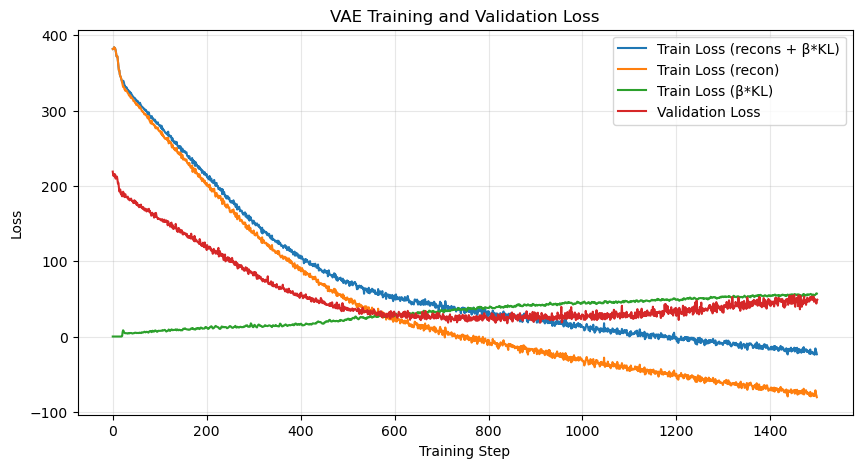

In [144]:
plot_loss_curves(tab_vae)

After 1500 epocs the validation loss got stable and reached a good range,Now we’ll make two datasets: one with the reconstructed training data and another with the newly generated data, so we can run the following evaluations.

In [145]:
recon_x, mu, logvar_z, logvar_x = tab_vae(torch.tensor(stacked_X_train))
recons = tab_vae.sample(recon_x.detach(), logvar_x.detach())
df_reconstructed = transformer.inverse_transform(recons)

In [146]:
def generate_sample(model, transformer, n=1000):
    # Generate new data and assign labels
    model.eval()
    with torch.no_grad():
        num_samples = n 
        steps = num_samples // batch_size + 1
        data = []
        for _ in range(steps):
            z = torch.randn(batch_size, model.latent_dim) 
            recon_x, logvar_out = model.decode(z)
            x = model.sample(recon_x, logvar_out)
            data.append(x)
        data = torch.cat(data, dim=0)
        # print(data.shape)
        df_generated = transformer.inverse_transform(data)
    return df_generated

In [147]:
df_generated = generate_sample(tab_vae, transformer, n=stacked_X_train.shape[0])

In [148]:
statistic_results(df_train, df_reconstructed, continuous_cols, categorical_cols)

total_phenols KS Stat: 0.9296
flavanoids KS Stat: 0.9437
alcohol KS Stat: 0.9155
ash KS Stat: 0.9155
alcalinity_of_ash KS Stat: 0.8944
magnesium KS Stat: 0.9085
proanthocyanins KS Stat: 0.8944
color_intensity KS Stat: 0.9577
hue KS Stat: 0.9155
proline KS Stat: 0.9155
malic_acid KS Stat: 0.8169
od280/od315_of_diluted_wines KS Stat: 0.8099
nonflavanoid_phenols KS Stat: 0.8451
target TV Stat: 0.9930
mean score is 0.9039


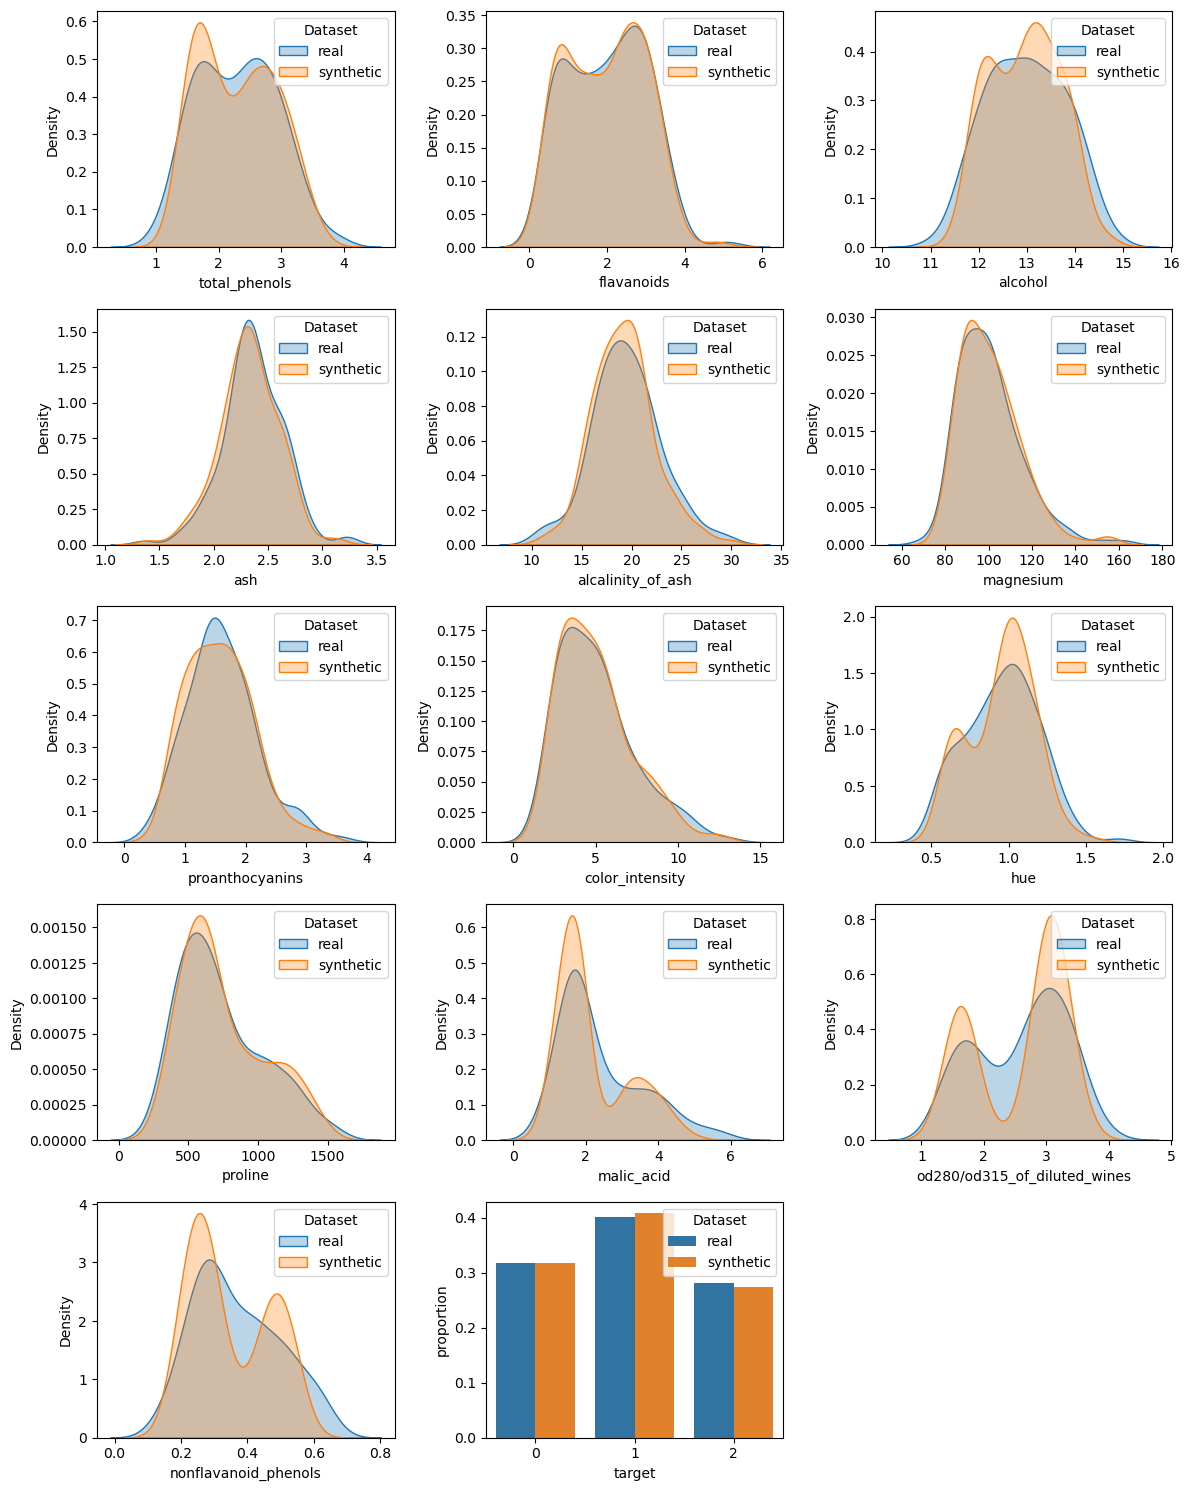

In [149]:
plot_real_vs_synthetic(df_train, df_reconstructed, continuous_cols, categorical_cols)

In [150]:
statistic_results(df_train, df_generated, continuous_cols, categorical_cols)

total_phenols KS Stat: 0.8671
flavanoids KS Stat: 0.8396
alcohol KS Stat: 0.8175
ash KS Stat: 0.8616
alcalinity_of_ash KS Stat: 0.8626
magnesium KS Stat: 0.7910
proanthocyanins KS Stat: 0.7852
color_intensity KS Stat: 0.7695
hue KS Stat: 0.8816
proline KS Stat: 0.8528
malic_acid KS Stat: 0.7782
od280/od315_of_diluted_wines KS Stat: 0.7703
nonflavanoid_phenols KS Stat: 0.7843
target TV Stat: 0.8908
mean score is 0.8251


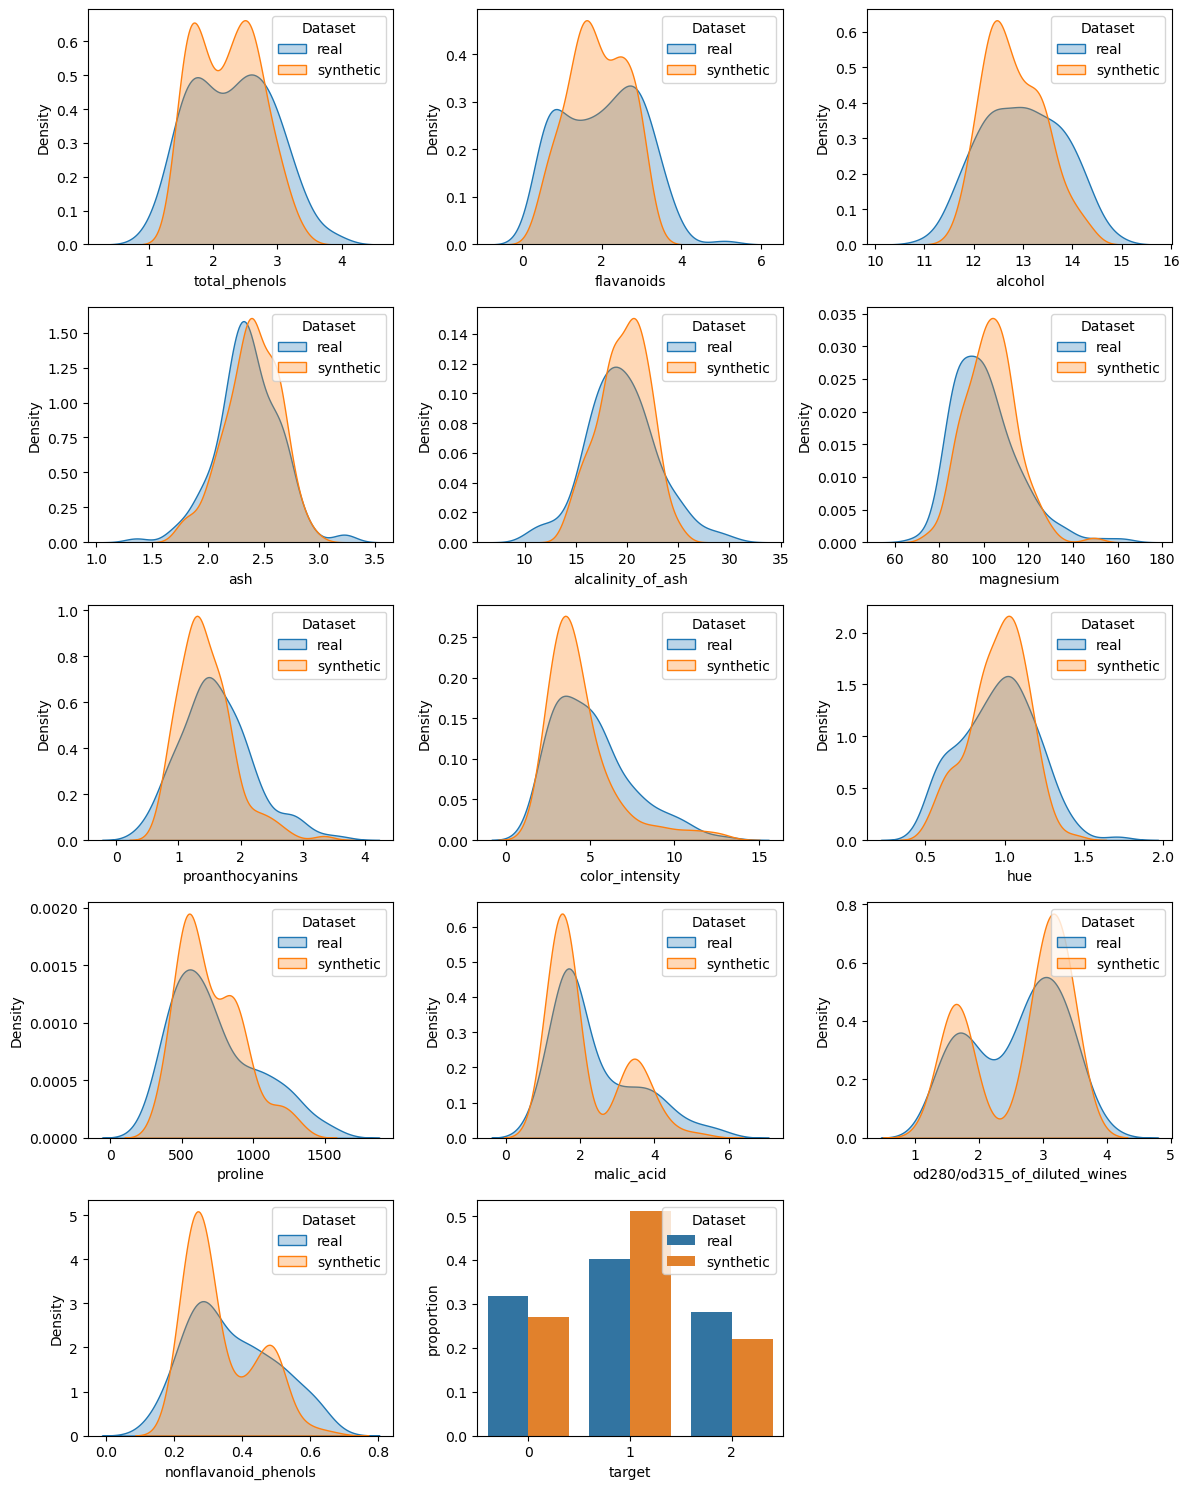

In [151]:
plot_real_vs_synthetic(df_train, df_generated, continuous_cols, categorical_cols)

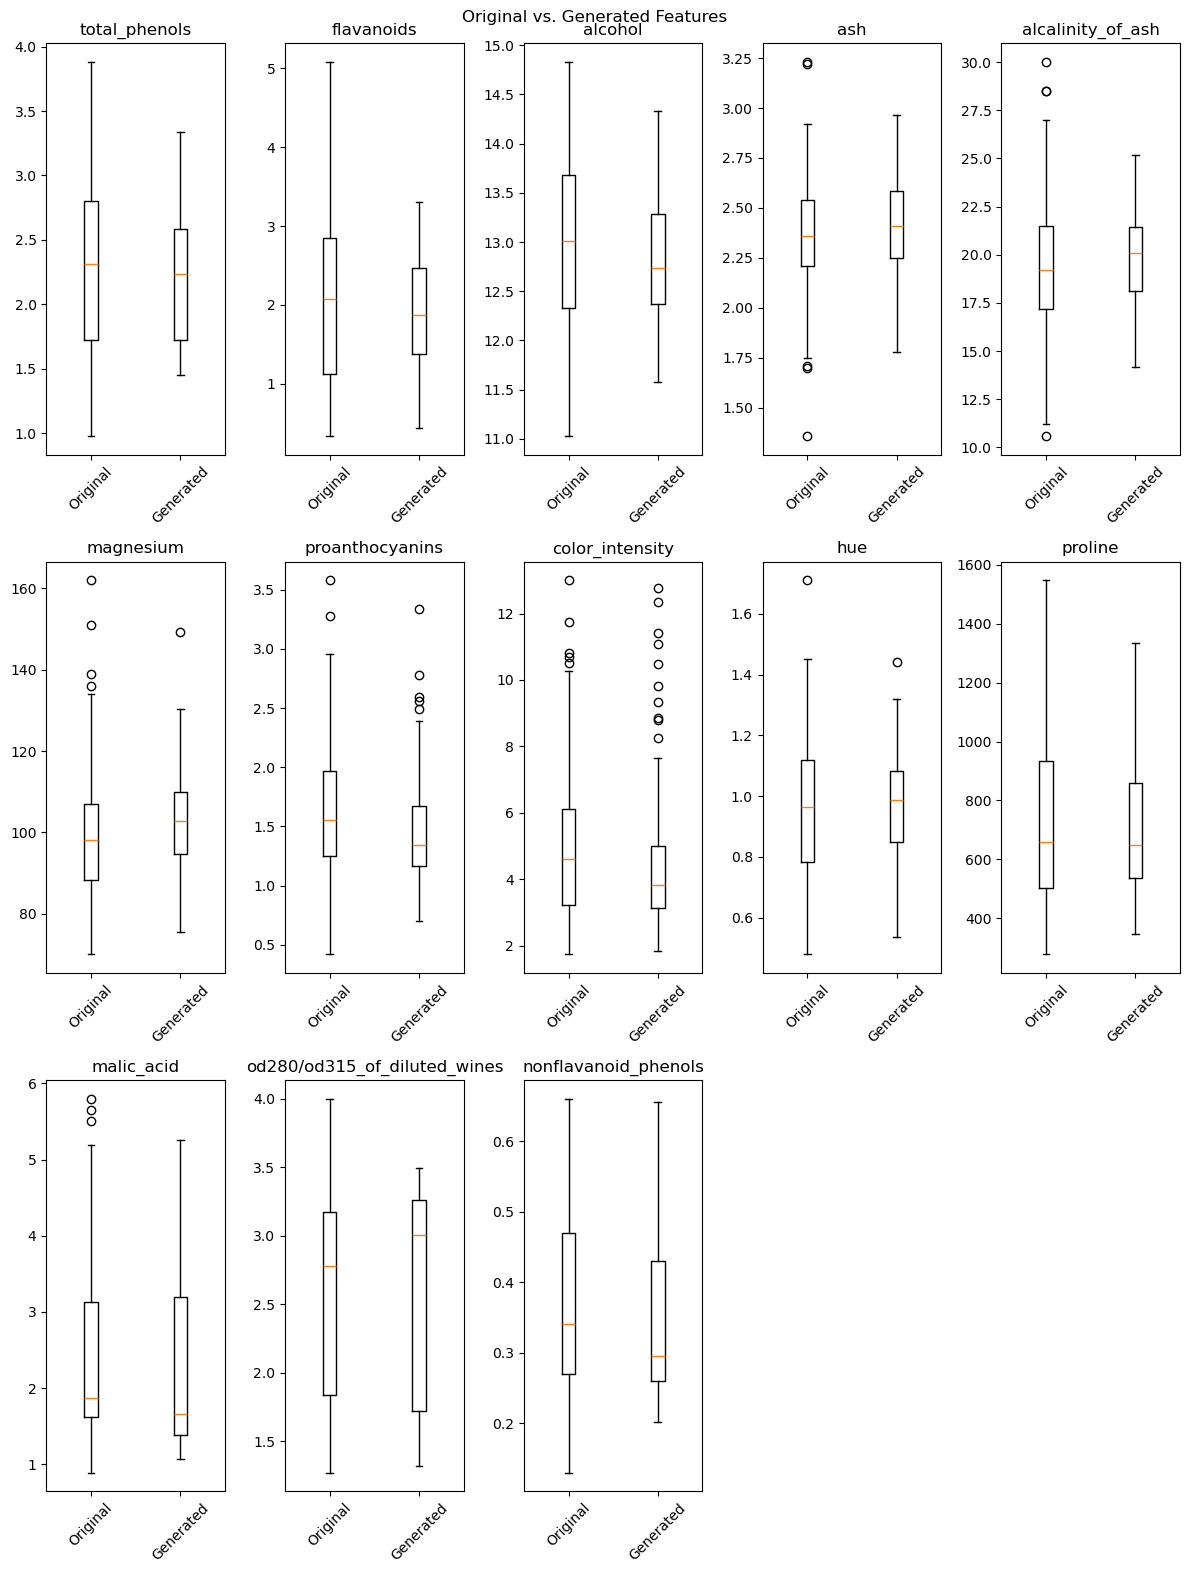

In [152]:
# Assume df (original) and df_generated are loaded
selected_features = continuous_cols

plt.figure(figsize=(12, 16))
for i, feature in enumerate(selected_features):
    plt.subplot(3, 5, i + 1)
    plt.boxplot([df_train[feature], df_generated[feature]], labels=['Original', 'Generated'])
    plt.title(feature)
    plt.xticks(rotation=45)
plt.suptitle('Original vs. Generated Features')
plt.tight_layout()
plt.show()

In [153]:
df_train['target'].value_counts()

target
1    57
0    45
2    40
Name: count, dtype: int64

In [154]:
df_generated['target'].value_counts()

target
1    72
0    38
2    31
Name: count, dtype: int64

In [155]:
X_gen = df_generated[feature_names].values
y_gen = df_generated['target'].values.astype(int)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
print(y_gen.dtype, y_train.dtype, y_test.dtype)

int64 int64 int64


In [156]:
classifiers = {'ada':'NoScaler','rf':'NoScaler','lr':'Standard','mlp':'Standard'}
result_mat_gen, result_mat_train = get_efficacy_metrics(X_gen, y_gen, X_train, y_train, X_test, y_test)
result_df_using_generated_dataset  = pd.DataFrame(result_mat_gen, columns=["Acc","F1_Score","Macro","Micro"]) 
result_df_using_train_dataset  = pd.DataFrame(result_mat_train, columns=["Acc","F1_Score","Macro","Micro"]) 
result_df_using_generated_dataset.index = classifiers
result_df_using_train_dataset.index = classifiers
print("generated dataset scores:\n", result_df_using_generated_dataset, '\n')
print("train dataset scores:\n", result_df_using_train_dataset)

/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer:

generated dataset scores:
            Acc  F1_Score     Macro     Micro
ada  50.000000  0.370370  0.222222  0.500000
rf   77.777778  0.777778  0.552381  0.777778
lr   77.777778  0.775336  0.542125  0.777778
mlp  50.000000  0.370370  0.222222  0.500000 

train dataset scores:
             Acc  F1_Score     Macro     Micro
ada   94.444444   0.94363  0.958486  0.944444
rf   100.000000   1.00000  1.000000  1.000000
lr   100.000000   1.00000  1.000000  1.000000
mlp  100.000000   1.00000  1.000000  1.000000


The similarity score was about 90 percent, and the machine learning classification tests gave a reasonable result, considering we didn’t tune them.

## Conclusion

In the context of generative models, VAEs have proven to be highly effective. The generated data is comparable in quality to that of other generative approaches, while being considerably faster to train than models such as GANs. This tutorial provided a basic introduction to VAEs and how they can be used with tabular data; however, there are many more advanced variants of VAEs that address some of the limitations of the simple VAE.

**Note:** For a deeper and more precise intuition about VAEs, you can refer to the seminal paper by [Kingma and Welling (2014)](https://arxiv.org/abs/1312.6114). In addition, [Lilian Weng](https://lilianweng.github.io/posts/2018-08-12-vae/) has written an excellent blog post on autoencoders and several VAE variants, which I highly recommend reading, And finally, here’s the main article that fixes most of the issues with a simple VAE on tabular data, you should definitely check it out: : [Tazwar et al 2024](https://www.scitepress.org/Papers/2024/123024/123024.pdf)